In [32]:
import os
from dateutil import rrule
from datetime import datetime, timedelta, date
import random
import itertools
import collections
import IPy
import numpy as np
import pandas as pd
import subprocess
import IPython.display
import re
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
import matplotlib.patches as mpatches
import time
import calendar
import networkx as nx
import sys
import slack
import asyncio
from IPython.display import display_html
from IPython.display import Javascript
from IPython.display import HTML
from matplotlib.ticker import ScalarFormatter
import matplotlib.ticker as ticker

import pyarrow as pa
os.environ["ARROW_LIBHDFS_DIR"] = "/usr/local/hadoop/lib/native"

# Find Spark
import findspark
findspark.init()

# PySpark imports
import pyspark
import pyspark.sql.functions as psf
import pyspark.sql.types as pst
from pyspark.ml.feature import Tokenizer, RegexTokenizer, HashingTF, CountVectorizer, CountVectorizerModel
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.types import BooleanType
from pyspark.sql.functions import udf,col, size
from pyspark.sql.types import StringType, ArrayType, StructType, StructField, IntegerType, MapType
from pyspark.sql.functions import broadcast
from pyspark.sql.functions import lit
from pyspark.sql.functions import substring
from pyspark.sql.functions import length
from pyspark.sql.functions import desc, asc
from pyspark.sql import Row
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import arrays_zip
from pyspark.sql.functions import avg, first
from pyspark.sql import Window
from pyspark.ml.evaluation import ClusteringEvaluator

os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.6.0-spark2.3-s_2.11 pyspark-shell'

In [2]:
APP_NAME = "mathay-pyspark-analysis"

EXTERNAL_DRIVER_IP = "192.87.172.56" # Your external IP address, for callback connections to the Spark driver
OI_KRB_PRINCIPAL = "mathay"          # Your assigned username, i.e., Kerberos principal

OI_KRB_KEYTAB    = os.path.join(     # Your Kerberos keytab
    os.path.expanduser("~"),
    "{}.keytab".format(OI_KRB_PRINCIPAL)
)

## DO NOT CHANGE THE CONFIGURATION BELOW UNLESS YOU KNOW WHAT YOU ARE DOING
spark_conf = pyspark.SparkConf().setAppName(APP_NAME
).setMaster("yarn").set("spark.scheduler.pool", "root.users.{}".format(OI_KRB_PRINCIPAL)
).set("spark.submit.deployMode", "client"
).set("spark.authenticate", "true"
).set("spark.sql.parquet.binaryAsString", "true"
).set("spark.network.crypto.enabled", "true"
).set("spark.driver.host", EXTERNAL_DRIVER_IP
).set("spark.driver.bindAddress", "0.0.0.0"
).set("spark.driver.port", "33000").set("spark.blockManager.port", "33016").set("spark.ui.port", "33032"
).set("spark.driver.cores","2").set("spark.driver.memory","4G"
).set("spark.executor.cores", "5").set("spark.executor.memory", "12G").set("spark.executor.memoryOverhead", "4G"
# ).set("spark.executor.cores", "5").set("spark.executor.memory", "12G").set("spark.executor.memoryOverhead", "4G"
).set("spark.dynamicAllocation.enabled", "true").set("spark.shuffle.service.enabled", "true" # dynamic ori is True
# ).set("spark.ui.showConsoleProgress", "true").set("spark.eventLog.logBlockUpdates.enabled", "true"
# ).set("spark.eventLog.enabled", "true").set("spark.eventLog.dir", "file:/tmp/spark-events") # I added the last 2 lines
# 4, 12, 4, 5 cores
)#.set("spark.dynamicAllocation.maxExecutors", "12") # deze heb ik toegevoegd

In [3]:
# A helper to kinit, keytab-based
def kinit_helper(principal, keytab):
    
    kinit_cmd = "kinit -p {} -k -t {} -l 7d -r 7d".format(principal, keytab)
    
    # Call subprocess to execute cmd
    process = subprocess.Popen(kinit_cmd, stdin=None, stdout=subprocess.PIPE, stderr=subprocess.PIPE, shell=True, executable="/bin/bash")
    output, error = process.communicate()
    
    stdout_str = error.decode("utf-8")
    if len(stdout_str) > 0:
        print(stdout_str)
    
    stderr_str = error.decode("utf-8")
    if len(stderr_str) > 0:
        print(stderr_str)
        
# A helper to get a (pyarrow) hdfs client
def hdfs_fs_helper(principal, host="default"):
    
    # Create a HDFS connection
    return pa.hdfs.connect(host=u"{}".format(host), port=0, user=u"{}".format(principal), kerb_ticket=u"/tmp/krb5cc_{}".format(os.getuid()), driver=u"libhdfs")

In [4]:
kinit_helper(OI_KRB_PRINCIPAL, OI_KRB_KEYTAB)

# SparkContext
sc = pyspark.SparkContext(conf=spark_conf)
print(sc.applicationId)

# SQLContext
sqlc = pyspark.SQLContext(sc)

application_1597403588481_0228


In [5]:
# sc.stop()

In [6]:
# Call the Garbage Collector explicitly
sc._jvm.System.gc()

In [7]:
sqlc.clearCache()

In [8]:
%autosave 0

Autosave disabled


# Loading data

In [ ]:
# Not used anymore
months = {1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 6: "June", 7: "July", 8: "August",
          9: "September", 10: "October", 11: "November", 12: "December"}
days_months = {1: 31, 2: 28, 3:31, 4: 30, 5: 31, 6: 30, 7: 31, 8: 31, 9: 30, 10: 31, 11: 30, 12: 31}

data = {}
# loading data, structure: data["1-3-2015'][0] or data["1-3-2015"][6][d] d of depth
for y in range(2015, 2021): # moet 2021 worden
    for m in range(1, 13):
        for d in range(1, days_months[m] + 1):
            day = []
            print(str(d) + " " + months[m] + " " + str(y))
            date = str(d) + "-" + str(m) + "-" + str(y)
            try:
                day.append(sqlc.read.parquet("/user/mathay/results/adoption-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)))
#                 day.append(sqlc.read.parquet("/user/mathay/results/mechanisms-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)))
#                 day.append(sqlc.read.parquet("/user/mathay/results/qualifiers-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)))
#                 day.append(sqlc.read.parquet("/user/mathay/results/combination-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)))
#                 day.append(sqlc.read.parquet("/user/mathay/results/include-top-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)))
#                 day.append(sqlc.read.parquet("/user/mathay/results/validation-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)))
#                 day.append(sqlc.read.parquet("/user/mathay/results/validation-full-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)))
#                 day.append(sqlc.read.parquet("/user/mathay/results/invalid-dns-limit-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)))
                include = []
#                 for i in range(6):
#                     include.append(sqlc.read.parquet("/user/mathay/results/spf-include-analysis/year={:4d}/month={:02d}/day={:02d}/depth={}".format(y, m, d, i)))
#                 day.append(include)
                data[date] = day
            except:
                print("done")
                break


# count-variables

In [9]:
# Creates figures for all the mechanisms, qualifiers, modifiers
datasets = ['com', 'org', 'net', 'alexa']
mechanisms_all_data = {'org' : {}, 'com' : {}, 'net' : {}, 'alexa' : {}}
d = 1
for dataset in datasets:
    for y in range(2015, 2021):
        for m in range(1, 13):
            print(m, y)
            try:
                mechanisms_all_data[dataset][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format(dataset, 'count-variables', y, m, d)).collect()
            except:
                continue

1 2015
2 2015
3 2015
4 2015
5 2015
6 2015
7 2015
8 2015
9 2015
10 2015
11 2015
12 2015
1 2016
2 2016
3 2016
4 2016
5 2016
6 2016
7 2016
8 2016
9 2016
10 2016
11 2016
12 2016
1 2017
2 2017
3 2017
4 2017
5 2017
6 2017
7 2017
8 2017
9 2017
10 2017
11 2017
12 2017
1 2018
2 2018
3 2018
4 2018
5 2018
6 2018
7 2018
8 2018
9 2018
10 2018
11 2018
12 2018
1 2019
2 2019
3 2019
4 2019
5 2019
6 2019
7 2019
8 2019
9 2019
10 2019
11 2019
12 2019
1 2020
2 2020
3 2020
4 2020
5 2020
6 2020
7 2020
8 2020
9 2020
10 2020
11 2020
12 2020
1 2015
2 2015
3 2015
4 2015
5 2015
6 2015
7 2015
8 2015
9 2015
10 2015
11 2015
12 2015
1 2016
2 2016
3 2016
4 2016
5 2016
6 2016
7 2016
8 2016
9 2016
10 2016
11 2016
12 2016
1 2017
2 2017
3 2017
4 2017
5 2017
6 2017
7 2017
8 2017
9 2017
10 2017
11 2017
12 2017
1 2018
2 2018
3 2018
4 2018
5 2018
6 2018
7 2018
8 2018
9 2018
10 2018
11 2018
12 2018
1 2019
2 2019
3 2019
4 2019
5 2019
6 2019
7 2019
8 2019
9 2019
10 2019
11 2019
12 2019
1 2020
2 2020
3 2020
4 2020
5 2020
6 2020
7

In [10]:
mechanisms_corrected = mechanisms_all_data
mechanisms_corrected_without_all = mechanisms_all_data
datasets = ['com', 'org', 'net', 'alexa']
qualifiers = ['+', '-', '?', '~']
for dataset in datasets:
    dfs = mechanisms_corrected[dataset]
    for date, rows in dfs.items():
        for qual in qualifiers:
            count = 0
            count_without_all = 0
            for row in rows:
                if row['key'].startswith(qual) and qual is not row['key']:
                    count += row['count']
                    if 'all' not in row['key']:
                        count_without_all += row['count']
#             for row in rows:
#                 if row[key] == qual:
#                     mechanisms_corrected[dataset][date]
            
            for i, row in enumerate(rows):
                if row['key'] == qual:
                    print(rows[i])
                    old_row = rows[i]
                    new_row = replace_row = Row(key=old_row['key'], count=count, total_domains=old_row['total_domains'])
                    rows.remove(old_row)
                    rows.append(new_row)
                    break
            
#             mechanisms_corrected[dataset][date]

Row(key='+', count=9649115, total_domains=22745856)
Row(key='-', count=6716814, total_domains=22745856)
Row(key='?', count=6089742, total_domains=22745856)
Row(key='~', count=9106911, total_domains=22745856)
Row(key='+', count=9557967, total_domains=21192267)
Row(key='-', count=4999485, total_domains=21192267)
Row(key='?', count=6065230, total_domains=21192267)
Row(key='~', count=9295567, total_domains=21192267)
Row(key='+', count=9568413, total_domains=22170274)
Row(key='-', count=5852334, total_domains=22170274)
Row(key='?', count=6044133, total_domains=22170274)
Row(key='~', count=9458280, total_domains=22170274)
Row(key='+', count=9603508, total_domains=23712211)
Row(key='-', count=7535360, total_domains=23712211)
Row(key='?', count=6012946, total_domains=23712211)
Row(key='~', count=9344691, total_domains=23712211)
Row(key='+', count=9721194, total_domains=23900762)
Row(key='-', count=7508547, total_domains=23900762)
Row(key='?', count=5994365, total_domains=23900762)
Row(key='~',

In [11]:
qualifiers = ["+", "-", "~", "?"]
mechanisms = ["all", "include", "a", "mx", "ptr", "ip4", "ip6", "exists", "redirect", "exp"]
combined_dict = {"all": {}, "include": {}, "a": {}, "mx": {}, "ptr": {}, "ip4": {}, "ip6": {}, "exists": {}, "redirect": {}, "exp": {}}
combined = mechanisms[:]
grouped_by_mechanisms = {"qualifiers": ["+", "-", "?", "~", "total"], "all": ["all", "total"], "include": ["include", "total"], "a": ["a", "total"], "mx": ["mx", "total"], "ptr": ["ptr", "total"], "ip4": ["ip4", "total"], "ip6": ["ip6", "total"], "exists": ["exists", "total"], "redirect": ["redirect", "total"], "exp": ["exp", "total"]}
for qualifier in qualifiers:
    for mechanism in mechanisms:
        combined.append(qualifier + mechanism)
        grouped_by_mechanisms[mechanism].append(qualifier + mechanism)
for qualifier in qualifiers:
    combined.append(qualifier)

In [12]:
mechanisms_data = {}
master_dataset = 'com'
for date in mechanisms_all_data[master_dataset]: # change to com later
    for dataset in datasets:
        try:
            for row in mechanisms_all_data[dataset][date]: # row is the current row in the old dataset with a date
                if date not in mechanisms_data:
                    mechanisms_data[date] = []
                    replace_row = Row(key=row[0], count=row[1], total_domains=row[2])
                else: # the date has been added before
                    added = False
                    for row_check_key in mechanisms_data[date]:
                        if row_check_key['key'] == row['key']: # The row has been added before
                            replace_row = Row(key=row['key'], count=row_check_key['count']+row['count'], total_domains=row_check_key['total_domains']+row['total_domains'])
                            mechanisms_data[date].remove(row_check_key)
                            added = True
                            break
                    if not added:
#                         replace_row = Row(key=row['key'], count=row['count'], total_domains=row['total_domains'])
                        replace_row = row

                mechanisms_data[date].append(replace_row)
        except:
            continue
print(mechanisms_data)
    

{'1-3-2015': [Row(count=0, key='-redirect', total_domains=26832100), Row(count=2, key='+redirect', total_domains=26832100), Row(count=462506, key='redirect', total_domains=26832100), Row(count=124683, key='?include', total_domains=26832100), Row(count=0, key='?redirect', total_domains=26832100), Row(count=9668112, key='mx', total_domains=26832100), Row(count=155720, key='+include', total_domains=26832100), Row(count=14, key='~include', total_domains=26832100), Row(count=76, key='-include', total_domains=26832100), Row(count=0, key='~redirect', total_domains=26832100), Row(count=11960140, key='include', total_domains=26832100), Row(count=108129, key='+all', total_domains=26832100), Row(count=115, key='~ptr', total_domains=26832100), Row(count=48, key='-exists', total_domains=26832100), Row(count=78, key='+exists', total_domains=26832100), Row(count=1, key='~exists', total_domains=26832100), Row(count=922573, key='ip6', total_domains=26832100), Row(count=19388, key='+ip6', total_domains=

In [ ]:
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            rows = mechanisms_data['1-' + str(m) + '-' + str(y)]
            a = None
            plus_a = None
            min_a = None
            question_a = None
            tilde_a = None
            mechanism = 'exp'
            for row in rows:
                if row['key'] == mechanism:
                    a = row
                if row['key'] == '+' + mechanism:
                    plus_a = row
                if row['key'] == '-' + mechanism:
                    min_a = row
                if row['key'] == '?' + mechanism:
                    question_a = row
                if row['key'] == '~' + mechanism:
                    tilde_a = row
            print(m, y)
            print(mechanism + ": ", a['count'] / a['total_domains'])
            print(mechanism + "+: ", plus_a['count'] / plus_a['total_domains'])
            print("+" + mechanism + ": ", plus_a['count'])
            print("combined: ", (a['count'] + plus_a['count']) / a['total_domains'])
            print("total: ", (a['count'] + plus_a['count'] + min_a['count'] + question_a['count'] + tilde_a['count']) / a['total_domains'])
            print("low usages absolute: ", plus_a['count'] + min_a['count'] + question_a['count'] + tilde_a['count'])
            print("usages absolute: ", a['count'] + plus_a['count'] + min_a['count'] + question_a['count'] + tilde_a['count'])
            print()
        except:
            continue

In [ ]:
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            rows = mechanisms_all_data['alexa']['1-' + str(m) + '-' + str(y)]
            a = None
            plus_a = None
            min_a = None
            question_a = None
            tilde_a = None
            mechanism = 'mx'
            for row in rows:
                if row['key'] == mechanism:
                    a = row
                if row['key'] == '+' + mechanism:
                    plus_a = row
                if row['key'] == '-' + mechanism:
                    min_a = row
                if row['key'] == '?' + mechanism:
                    question_a = row
                if row['key'] == '~' + mechanism:
                    tilde_a = row
            print(m, y)
            print(mechanism + ": ", a['count'] / a['total_domains'])
            print(mechanism + "+: ", plus_a['count'] / plus_a['total_domains'])
            print("combined: ", (a['count'] + plus_a['count']) / a['total_domains'])
            print("total: ", (a['count'] + plus_a['count'] + min_a['count'] + question_a['count'] + tilde_a['count']) / a['total_domains'])
            print()
        except:
            continue

In [ ]:
print(grouped_by_mechanisms)
for key, items in grouped_by_mechanisms.items():
    if key != "qualifiers":
        items.append(items.pop(1))
print(grouped_by_mechanisms)

In [ ]:
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            print(m, y)
            rows = mechanisms_data["1-" + str(m) + "-" + str(y)]
            total = 0
            for row in rows:
                if row["key"] in grouped_by_mechanisms["exists"]:
                    print(row["key"] + ": " + str(row["count"] / row["total_domains"]))
                    total += row["count"] / row["total_domains"]
            print("total:", total)
        except:
            continue

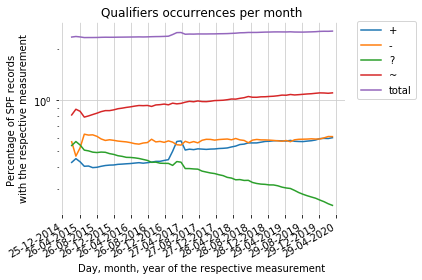

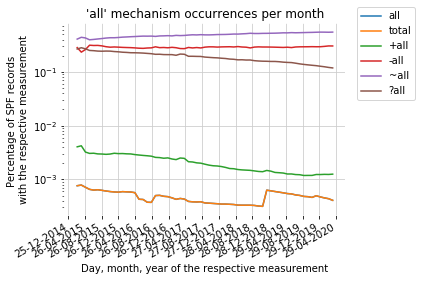

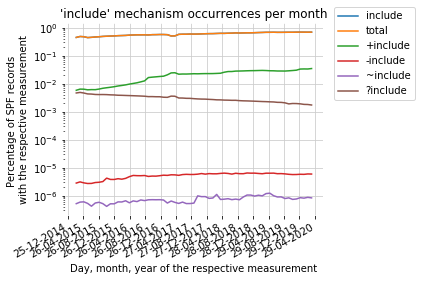

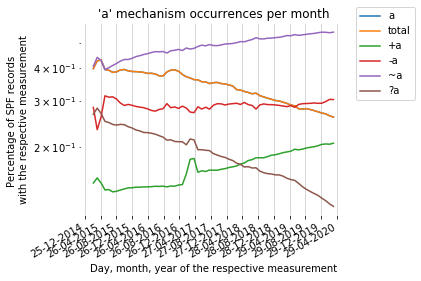

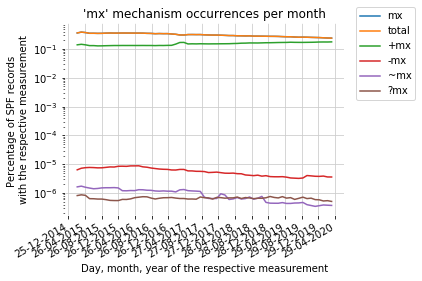

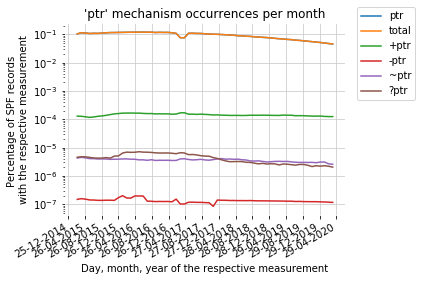

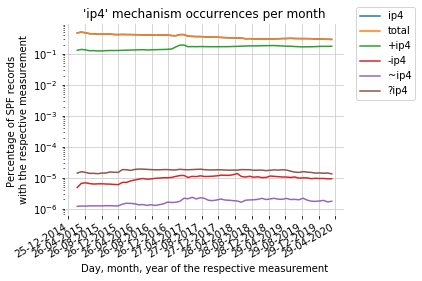

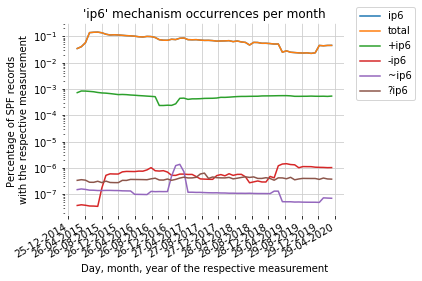

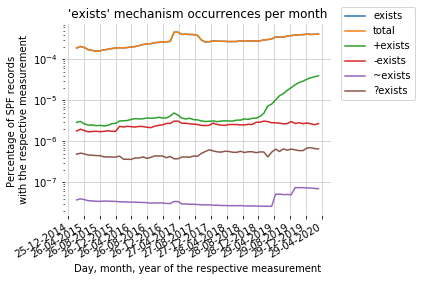

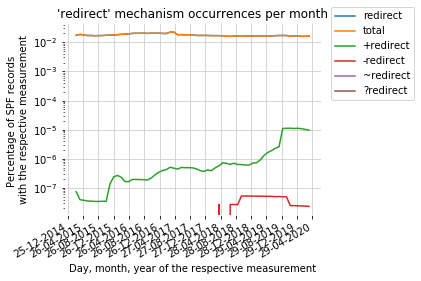

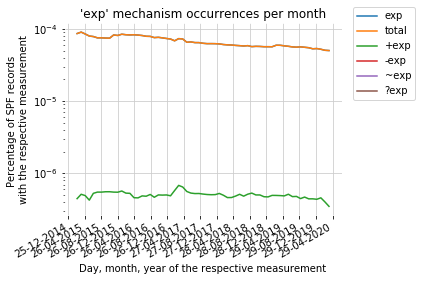

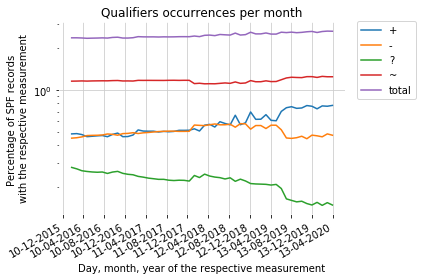

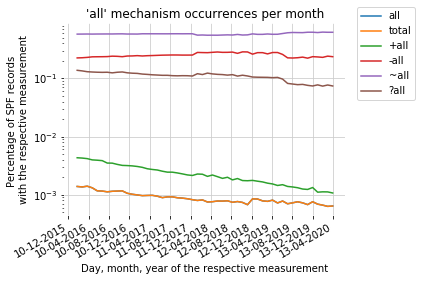

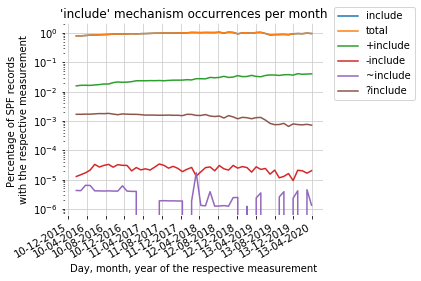

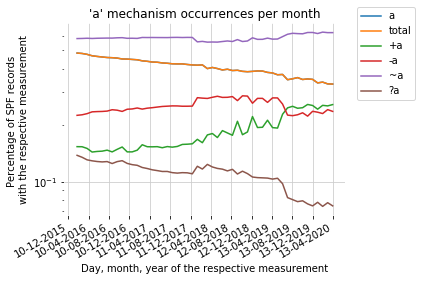

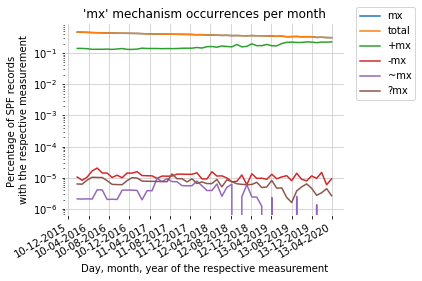

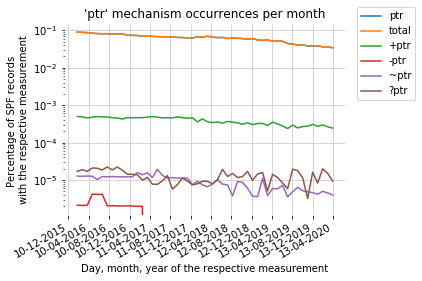

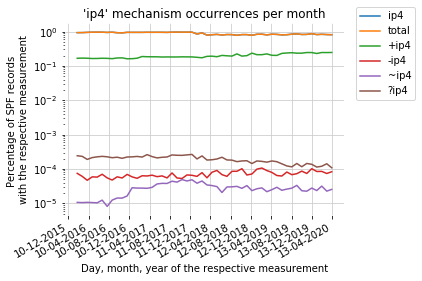

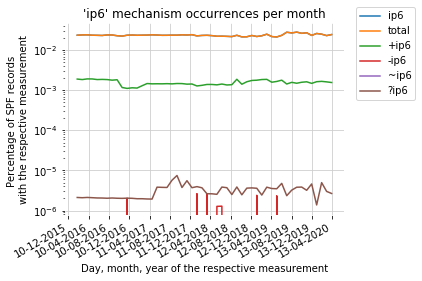

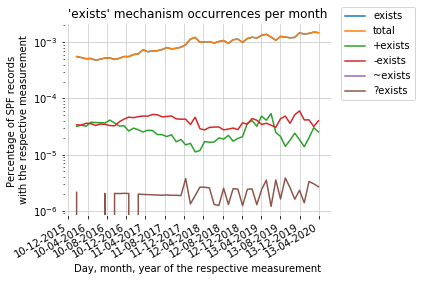

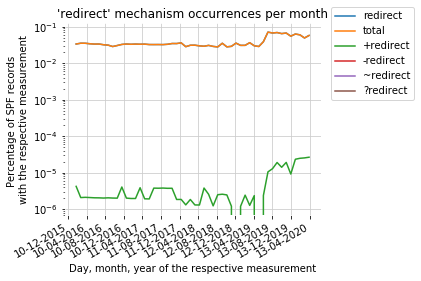

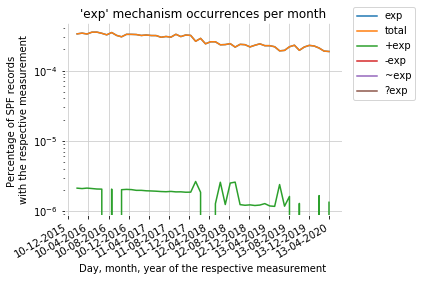

In [33]:
new_datasets = ['main', 'alexa']
for dataset in new_datasets:
    if dataset == 'main':
        data = mechanisms_data
    else:
        data = mechanisms_all_data[dataset]
    
    for key, mech_combinations_list in grouped_by_mechanisms.items():
        y_axis_total = {}
        for mech in mech_combinations_list:
            y_axis = []
            x_axis = []
            
            if mech == 'total':
                x_axis = list(y_axis_total.keys())
                y_axis = list(y_axis_total.values())
            else:
                for date, df in data.items():  
                    for row in df:     
                        if row['key'] == mech:
                            x_axis.append(date)
                            y_axis.append(int(row['count']) / int(row['total_domains']))
                            
                            if date in y_axis_total:
                                y_axis_total[date] += int(row['count']) / int(row['total_domains'])
                            else:
                                y_axis_total[date] = int(row['count']) / int(row['total_domains'])
                                
                            break
                            
            first_date_splitted = x_axis[0].split("-")
            first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
            last_date_splitted = x_axis[-1].split("-")
            last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

            i = 1
            days = []
            while len(days) != len(y_axis):
                if len(y_axis) - len(days) == 1:
                    days = np.append(days, np.array([737539.]))
#                     print("via extra handmatig toegevoegde dag")
                    break
                days = mdate.drange(first, last, timedelta(days=i))
                if i > 1000:
                    print("No solution found")
                    break
                i += 1
                
            colors = {'total': 'brown', '+': 'orange', '-': 'green', '~': 'red', '?': 'purple'}
            color = 'blue'
            try:
                color = colors[mech[0:1]]
            except:
                color = 'blue'

            if len(days) != len(y_axis):
                print(len(days))
                print(len(y_axis))
                print("ze zijn niet gelijk")
                plt.plot(x_axis, y_axis)
            else:
                plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
                plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
                label = mech if mech != "total" else "total"
                plt.plot(days, y_axis, label=label)
        plt.gcf().autofmt_xdate()
        plt.title("'" + key + "' mechanism occurrences per month")
        if key == 'qualifiers':
            plt.title("Qualifiers occurrences per month")
        plt.xlabel("Day, month, year of the respective measurement")
        plt.ylabel("Percentage of SPF records \nwith the respective measurement")
#         plt.ylabel("Average number of occurrences of the \nrespective measurement in an SPF record")
        plt.legend(loc=(1.04,0.60))
    
#         plt.rcParams['axes.facecolor'] = 'white'
#         plt.rcParams['axes.edgecolor'] = 'white'
#         plt.rcParams['axes.grid'] = True
#         plt.rcParams['grid.alpha'] = 1
#         plt.rcParams['grid.color'] = "#cccccc"
#         plt.grid(True)
        
#         ax = plt.axes(yscale='log')
#         ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))  
        
        plt.yscale("log")
        plt.tight_layout()
        plt.savefig("/home/sparky/figures_new/" + dataset + "/count-everything/" + str(key))
        plt.show()

In [ ]:
for mech in qualifiers:
    y_axis = []
    x_axis = []
    for date, df in mechanisms_data[dataset].items():
        for row in df:
            if row[0] == mech:
                x_axis.append(date)
                y_axis.append(int(row[1]) / int(row[2]))
                break

    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis):
        if len(y_axis) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
        plt.plot(days, y_axis)
    plt.gcf().autofmt_xdate()
    plt.title("'" + mech + "' mechanism occurances per month")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    plt.savefig("/home/sparky/figures_new/" + dataset + "/count-everything/" + mech)
    plt.show()

In [ ]:
for date, values in mechanisms_data.items():
    total_plus = 0
    total_plus_without_all = 0
    for row in values:
        if row['key'].startswith('-') and row['key'] is not '-':
            total_plus += row['count']
            if 'all' not in row['key']:
                total_plus_without_all += row['count']
            print(row)
#     print(values)
    print(date)
    print(total_plus)
    print(total_plus_without_all)
    break

In [ ]:
print(mechanisms_data['1-3-2015'])

In [ ]:
print(grouped_by_mechanisms)

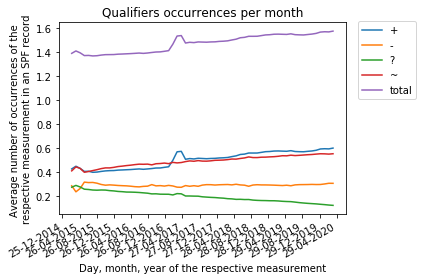

In [31]:
data = mechanisms_data
# data = mechanisms_all_data['alexa'] # decide which of the two you want to use, main or Alexa
# data = mechanisms_corrected_without_all
grouped_only_qualifiers = {'qualifiers': ['+', '-', '?', '~', 'total']}
for key, mech_combinations_list in grouped_only_qualifiers.items():
    y_axis_total = {}
    for mech in mech_combinations_list:
        y_axis = []
        x_axis = []

        if mech == 'total':
            x_axis = list(y_axis_total.keys())
            y_axis = list(y_axis_total.values())
        else:
            for date, df in data.items():  
                x_axis.append(date)
                total_qual = 0
                for row in df:
                    if row['key'].startswith(mech) and row['key'] is not mech:
                        if 'all' not in row['key']:
                            total_qual += row['count']
#                 print(date, " ", total_qual)
#                 print(mech, total_qual / int(row['total_domains']))
#                 print(row['total_domains'])
                y_axis.append(total_qual / int(row['total_domains']))
                
                if date in y_axis_total:
                    y_axis_total[date] += total_qual / int(row['total_domains'])
                else:
                    y_axis_total[date] = total_qual / int(row['total_domains'])
#                 print(y_axis)
#         print(mech, y_axis)
        first_date_splitted = x_axis[0].split("-")
        first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
        last_date_splitted = x_axis[-1].split("-")
        last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
#                     print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            label = mech if mech != "total" else "total"
            plt.plot(days, y_axis, label=label)
    plt.gcf().autofmt_xdate()
    plt.title("'" + key + "' mechanism occurrences per month")
    if key == 'qualifiers':
        plt.title("Qualifiers occurrences per month")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    plt.ylabel("Average number of occurrences of the \nrespective measurement in an SPF record")
    plt.legend(loc=(1.04,0.60))
#     plt.yscale("log")
    plt.tight_layout()
    plt.savefig("/home/sparky/figures_new/" + dataset + "/count-everything/" + str(key))
    plt.show()

# adoption-rate

In [ ]:
# Creates the adoption rate figures
datasets = ['com', 'org', 'net', 'alexa']
adoption_data = {'org' : {}, 'com' : {}, 'net' : {}, 'alexa' : {}}
d = 1
for dataset in datasets:
    for y in range(2015, 2021):
        for m in range(1, 13):
            print(m, y)
            try:
                adoption_data[dataset][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format(dataset, 'adoption-rate', y, m, d)).collect()
            except:
                continue

In [ ]:
adoption_data_full = {}
master_dataset = 'com'
for date in adoption_data[master_dataset]: # change to com later
    for dataset in datasets:
        try:
            for row in adoption_data[dataset][date]: # row is the current row in the old dataset with a date
                if date not in adoption_data_full:
                    adoption_data_full[date] = None
                    replace_row = Row(total_domains=row['total_domains'], spf_domains=row['spf_domains'], adoption_rate=row['adoption_rate'])
                else: # the date has been added before
                    added = False
                    old_row = adoption_data_full[date]
                    total_domains = row['total_domains'] + old_row['total_domains']
                    spf_domains = row['spf_domains'] + old_row['spf_domains']
                    adoption_rate = spf_domains / total_domains
                    replace_row = Row(total_domains=total_domains, spf_domains=spf_domains, adoption_rate=adoption_rate)

                adoption_data_full[date] = replace_row
        except:
            continue
print(adoption_data_full)

In [ ]:
new_datasets = ['main', 'alexa']
for dataset in new_datasets:
    if dataset == 'main':
        data = adoption_data_full
    else:
        data = adoption_data[dataset]
    
    y_axis = []
    x_axis = []
    for date, df in data.items():
        if isinstance(df, list):
            df = df[0]
        x_axis.append(date)
        y_axis.append(df['adoption_rate'])

    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis):
        if len(y_axis) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
        plt.plot(days, y_axis)
    plt.gcf().autofmt_xdate()
    plt.title("Adoption rate of SPF on the $\it{" + str(dataset) + "}$ dataset")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    plt.savefig("/home/sparky/figures_new/" + dataset + "/adoption/adoption-rate")
    plt.show()

In [ ]:
# one figure
new_datasets = ['main', 'alexa']
for dataset in new_datasets:
    if dataset == 'main':
        data = adoption_data_full
    else:
        data = adoption_data[dataset]
    
    y_axis = []
    x_axis = []
    for date, df in data.items():
        if isinstance(df, list):
            df = df[0]
        x_axis.append(date)
        y_axis.append(df['adoption_rate'])

    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis):
        if len(y_axis) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
        plt.plot(days, y_axis)
plt.gcf().autofmt_xdate()
plt.title("Adoption rate of SPF on the $\it{" + str(dataset) + "}$ dataset")
plt.xlabel("Day, month, year of the respective measurement")
plt.ylabel("Percentage of SPF records \nwith the respective measurement")
plt.yticks([0.15, 0.20, 0.25, 0.5, 0.6, 0.7, 0.8])
plt.savefig("/home/sparky/figures_new/" + dataset + "/adoption/adoption-rate")
plt.show()

In [ ]:
for dataset in datasets:
    y_axis = []
    x_axis = []
    for date, df in adoption_data[dataset].items():
        for row in df:
            x_axis.append(date)
            y_axis.append(float(row[2]))
    
    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis):
        if len(y_axis) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
        plt.plot(days, y_axis)
    plt.gcf().autofmt_xdate()
    plt.title("Adoption rate of SPF of the '." + str(dataset) + "' dataset")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    plt.savefig("/home/sparky/figures_new/" + dataset + "/adoption/adoption-rate")
    plt.show()

# included-domains-count

In [ ]:
# Creates the figures of the included-domains-count and the Google's SPF issue
sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('com', 'included-domains-count', 2015, 5, 1))\
.sort(desc("count")).show(truncate=False)

In [ ]:
sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('com', 'included-domains-count', 2020, 5, 1))\
.sort(desc("count")).show(truncate=False)

In [ ]:
datasets = ['com', 'org', 'net', 'alexa']
included_domains_count_data = {'org' : {}, 'com' : {}, 'net' : {}, 'alexa' : {}}
d = 1
for dataset in datasets:
    for y in range(2015, 2021):
        for m in range(1, 13):
            print(m, y)
            try: # was eerst een .collect
                included_domains_count_data[dataset][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format(dataset, 'included-domains-count', y, m, d))
            except:
                continue

In [ ]:
d, m, y = 1, 5, 2020
sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format(dataset, 'included-domains-count', y, m, d)).show()

In [ ]:
# ToDo edit the rows
included_domains_count_data_full = {}
master_dataset = 'com'
for date in included_domains_count_data[master_dataset]: # change to com later
    for dataset in datasets:
        try:
            for row in included_domains_count_data[dataset][date]: # row is the current row in the old dataset with a date
                if date not in included_domains_count_data_full:
                    included_domains_count_data_full[date] = None
                    replace_row = Row(total_domains=row['total_domains'], spf_domains=row['spf_domains'], adoption_rate=row['adoption_rate'])
                else: # the date has been added before
                    added = False
                    old_row = included_domains_count_data_full[date]
                    total_domains = row['total_domains'] + old_row['total_domains']
                    spf_domains = row['spf_domains'] + old_row['spf_domains']
                    adoption_rate = spf_domains / total_domains
                    replace_row = Row(total_domains=total_domains, spf_domains=spf_domains, adoption_rate=adoption_rate)

                included_domains_count_data_full[date] = replace_row
        except:
            continue
print(adoption_data_full)

In [ ]:
domains = {}
for dataset in datasets:
    y_axis = []
    x_axis = []
    for date, df in included_domains_count_data[dataset].items():
        for row in df:
            x_axis.append(date)
            y_axis.append(float(row[2]))
    if 
    
    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis):
        if len(y_axis) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
        plt.plot(days, y_axis)
    plt.gcf().autofmt_xdate()
    plt.title("Adoption rate of SPF of the '." + str(dataset) + "' dataset")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    plt.savefig("/home/sparky/figures_new/" + dataset + "/adoption/adoption-rate")
    plt.show()

In [ ]:
for y in range(2015, 2021):
    print(sqlc.createDataFrame(included_domains_count_data[dataset]["1-3-" + str(y)]).orderBy(col("count").desc()).show(truncate=False))

In [ ]:
datasets = ['com-org-net']
included_domains_count_data_google = {'com-org-net' : {}}
d = 1
for dataset in datasets:
    for y in range(2015, 2021):
        for m in range(3, 4):
            print(m, y)
            try: # was eerst een .collect
                included_domains_count_data_google[dataset][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format(dataset, 'included-domains-count', y, m, d))
            except:
                continue

In [ ]:
dataset = 'com-org-net'
google_data = {"aspmx.googlemail.com": [], "_spf.google.com": []}
for y in range(2015, 2021):
    print(y)
#     test = sqlc.createDataFrame(included_domains_count_data[dataset]["1-3-" + str(y)]).filter(col('key') == 'aspmx.googlemail.com')
    test = included_domains_count_data_google[dataset]["1-3-" + str(y)].filter(col('key') == 'aspmx.googlemail.com')
    test = test.withColumn('percentage', lit(test[1] / test[2]))
    google_data['aspmx.googlemail.com'].append(test.select(test.percentage).collect())
    test.show(truncate=False)
#     test = sqlc.createDataFrame(included_domains_count_data[dataset]["1-3-" + str(y)]).filter(col('key') == '_spf.google.com')
    test = included_domains_count_data_google[dataset]["1-3-" + str(y)].filter(col('key') == '_spf.google.com')
    test = test.withColumn('percentage', lit(test[1] / test[2]))
    google_data['_spf.google.com'].append(test.select(test.percentage).collect())
    test.show(truncate=False)

In [ ]:
for url, y_axis_rows in google_data.items():
    x_axis = ["01-03-2015", "01-03-2016", "01-03-2017", "01-03-2018", "01-03-2019", "01-03-2020"]
    y_axis = []
    for row in y_axis_rows:
         y_axis.append(row[0][0])
    plt.plot(x_axis, y_axis, label=url)

plt.title("Relative usages of the respective URL in the $\it{main}$ dataset")
plt.xlabel("Day, month, year of the respective measurement")
plt.ylabel("Percentage of SPF records \nwith the respective measurement")
plt.legend(['aspmx.googlemail.com', ' _spf.google.com'], loc="upper left")
plt.savefig("/home/sparky/figures_new/other/google2spfrecordsnew")
plt.show()

In [ ]:
df = included_domains_count_data[dataset][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('net', 'validation-full-data', 2017, 5, 1))
df.filter(df.valid_spf_dns_limit == False).show()

# validation-data

In [ ]:
# Creates the figures of the validation data
datasets = ['com', 'org', 'net', 'alexa']


= {'org' : {}, 'com' : {}, 'net' : {}, 'alexa' : {}}
d = 1
for dataset in datasets:
    for y in range(2015, 2021):
        for m in range(1, 13):
            print(m, y)
            try:
                validation_data[dataset][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format(dataset, 'validation-data', y, m, d)).collect()
            except:
                continue

In [ ]:
print(validation_data['com']['1-5-2020'])
print(validation_data['org']['1-5-2020'])
print(validation_data['net']['1-5-2020'])
print(validation_data['alexa']['1-5-2020'])

In [ ]:
datasets = ['alexa']
for y in range(2016, 2021):
    valid = 0
    invalid = 0
    domains = 0
    for dataset in datasets:
        row = validation_data[dataset]['1-5-' + str(y)][0]
        valid += row['valid_spf_string']
        invalid += row['invalid_spf_string']
        domains += row['total_domains']
    print(y)
    print("valid:", valid)
    print("invalid:", invalid)
    print("percentage:", invalid / domains * 100)
    print("domains:", domains)
    print()

In [ ]:
validation_data_full = {}
master_dataset = 'com'
for date in validation_data[master_dataset]: # change to com later
    for dataset in datasets:
        try:
            for row in validation_data[dataset][date]: # row is the current row in the old dataset with a date
                if date not in validation_data_full:
                    validation_data_full[date] = None
                    replace_row = Row(valid_spf_string=row['valid_spf_string'], invalid_spf_string=row['invalid_spf_string'],
                                      valid_spf_dns=row['valid_spf_dns'], invalid_spf_dns=row['invalid_spf_dns'], total_domains=row['total_domains'],
                                      total_invalid_domains=row['total_invalid_domains'], both_invalid=row['both_invalid'])
                else: # the date has been added before
                    old_row = validation_data_full[date]
                    valid_spf_string = row['valid_spf_string'] + old_row['valid_spf_string']
                    invalid_spf_string=row['invalid_spf_string'] + old_row['invalid_spf_string']
                    valid_spf_dns=row['valid_spf_dns'] + old_row['valid_spf_dns']
                    invalid_spf_dns=row['invalid_spf_dns'] + old_row['invalid_spf_dns']
                    total_domains=row['total_domains'] + old_row['total_domains']
                    total_invalid_domains=row['total_invalid_domains'] + old_row['total_invalid_domains']
                    both_invalid=row['both_invalid'] + old_row['both_invalid']
                    replace_row = Row(valid_spf_string=valid_spf_string, invalid_spf_string=invalid_spf_string,
                                     valid_spf_dns=valid_spf_dns, invalid_spf_dns=invalid_spf_dns,
                                      total_domains = total_domains, total_invalid_domains=total_invalid_domains,
                                      both_invalid=both_invalid)

                validation_data_full[date] = replace_row
        except:
            continue
print(validation_data_full)

In [ ]:
new_datasets = ['all', 'alexa']
for dataset in new_datasets:
    if dataset == 'all':
        data = validation_data_full
    else:
        data = validation_data[dataset]
    
    y_axis_valid = []
    y_axis_invalid = []
    x_axis = []
    for date, df in data.items():
        if isinstance(df, list):
            df = df[0]
        x_axis.append(date)
        y_axis_valid.append((df['total_domains'] - df['total_invalid_domains']) / df['total_domains'])
        y_axis_invalid.append(df['total_invalid_domains'] / df['total_domains'])

    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis_valid):
        if len(y_axis_valid) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis_valid):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
#         plt.plot(days, y_axis)

        fig, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('Day, month, year of the respective measurement')
        ax1.set_ylabel('Percentage of SPF records \nwith the respective measurement', color=color)
        ax1.plot(days, y_axis_valid, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('Percentage of SPF records \nwith the respective measurement', color=color)  # we already handled the x-label with ax1
        ax2.plot(days, y_axis_invalid, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()

    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
    plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
    plt.title("(In)valid SPF records in the " + str(dataset) + " dataset")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    fig.legend(['Valid', 'Invalid'], loc=(0.67,0.52))
    fig.tight_layout()
    plt.savefig("/home/sparky/figures_new/" + dataset + "/validation/valid-" + str(dataset))
    plt.show()

In [ ]:
# plt.show()
# datasets = ['alexa', 'com']
for dataset in datasets:
    y_axis_valid = []
    y_axis_invalid = []
    x_axis = []
    for date, df in validation_data[dataset].items():
        for row in df:
            x_axis.append(date)
            y_axis_valid.append((row[4] - row[5]) / row[4])
            y_axis_invalid.append(row[5] / row[4])
    
    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis_valid):
        if len(y_axis_valid) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis_valid):
        print(len(days))
        print(len(y_axis_valid))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis_valid)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
#         plt.plot(days, y_axis_valid)
        
        fig, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('Day, month, year of the respective measurement')
        ax1.set_ylabel('Percentage of SPF records \nwith the respective measurement', color=color)
        ax1.plot(days, y_axis_valid, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('Percentage of SPF records \nwith the respective measurement', color=color)  # we already handled the x-label with ax1
        ax2.plot(days, y_axis_invalid, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()
        
        
    plt.gcf().autofmt_xdate()
    plt.title("Valid domains in the ." + str(dataset) + " dataset")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    fig.legend(['Valid', 'Invalid'], loc="best")
    plt.savefig("/home/sparky/figures_new/" + dataset + "/validation/validtest")
#     plt.show()

In [ ]:
for dataset in datasets:
    y_axis = []
    x_axis = []
    for date, df in validation_data[dataset].items():
        for row in df:
            x_axis.append(date)
            y_axis.append(row[5] / row[4])
    
    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis):
        if len(y_axis) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
        plt.plot(days, y_axis)
    plt.gcf().autofmt_xdate()
    plt.title("Valid domains in the ." + str(dataset) + " dataset")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    plt.savefig("/home/sparky/figures_new/" + dataset + "/validation/invalid")
    plt.show()

# invalid-dns-limit

In [ ]:
# Creates the figures about the invalid dns mechanisms data
datasets = ['com', 'org', 'net', 'alexa']
invalid_dns_limit_data = {'org' : {}, 'com' : {}, 'net' : {}, 'alexa' : {}}
d = 1
for dataset in datasets:
    for y in range(2015, 2021):
        for m in range(1, 13):
            print(m, y)
            try:
                invalid_dns_limit_data[dataset][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format(dataset, 'invalid-dns-limit', y, m, d)).collect()
            except:
                continue

In [ ]:
print(invalid_dns_limit_data['com']['1-5-2020'])
print(invalid_dns_limit_data['org']['1-5-2020'])
print(invalid_dns_limit_data['net']['1-5-2020'])
print(invalid_dns_limit_data['alexa']['1-5-2020'])

In [ ]:
invalid_dns_limit_data_full = {}
master_dataset = 'com'
for date in invalid_dns_limit_data[master_dataset]: # change to com later
    for dataset in datasets:
        try:
            for row in invalid_dns_limit_data[dataset][date]: # row is the current row in the old dataset with a date
                if date not in invalid_dns_limit_data_full:
                    invalid_dns_limit_data_full[date] = None
                    replace_row = Row(a=row['a'], exists = row['exists'], include = row['include'], mx = row['mx'],
                                     ptr = row['ptr'], invalid_records_count = row['invalid_records_count'],
                                     domains = row['domains'])
                else: # the date has been added before
                    old_row = invalid_dns_limit_data_full[date]
                    a = row['a'] + old_row['a']
                    exists = row['exists'] + old_row['exists']
                    include = row['include'] + old_row['include']
                    mx = row['mx'] + old_row['mx']
                    ptr = row['ptr'] + old_row['ptr']
                    invalid_records_count = row['invalid_records_count'] + old_row['invalid_records_count']
                    domains = row['domains'] + old_row['domains']
                    replace_row = Row(a=a, exists = exists, include = include, mx = mx,
                                     ptr = ptr, invalid_records_count = invalid_records_count,
                                     domains = domains)

                invalid_dns_limit_data_full[date] = replace_row
        except:
            continue
print(invalid_dns_limit_data_full)

In [ ]:
new_datasets = ['all', 'alexa']
items = ['a', 'domains', 'exists', 'include', 'invalid_records_count', 'mx', 'ptr']
for dataset in new_datasets:
    if dataset == 'all':
        data = invalid_dns_limit_data_full
    else:
        data = invalid_dns_limit_data[dataset]
    
    for mech in items:
        if mech == 'domains':
            continue
        y_axis = []
        x_axis = []
        for date, df in data.items():
            if isinstance(df, list):
                df = df[0]
            x_axis.append(date)
            if mech == 'invalid_records_count':
                y_axis.append(df[mech] / df['domains'])
            else:
                y_axis.append(df[mech] / df['invalid_records_count'])

        first_date_splitted = x_axis[0].split("-")
        first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
        last_date_splitted = x_axis[-1].split("-")
        last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
                print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            plt.plot(days, y_axis, label=mech)
            
    plt.gcf().autofmt_xdate()
    plt.title("Mechanisms occurrences in invalid SPF records\n due to DNS lookup limits in the '" + str(dataset) + "' dataset")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    plt.yscale("log")
    plt.legend(loc=(1.04,0.45))
#     plt.tight_layout()
    plt.savefig("/home/sparky/figures_new/" + dataset + "/dns-limit/dns-limit")
    plt.show()

# validation-full-data (syntax errors/clustering)

In [ ]:
# Performs clustering on the syntax errors
datasets = ['com', 'org', 'net', 'alexa']
validation_full_dataset = {'org' : {}, 'com' : {}, 'net' : {}, 'alexa' : {}}
d = 1
for dataset in datasets:
    for y in range(2020, 2021):
        for m in range(5, 6):
            print(m, y)
            try:
                validation_full_dataset[dataset][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format(dataset, 'validation-full-data', y, m, d))
            except:
                continue

In [ ]:
validation_full_dataset['com']['1-5-2020'].show()

In [ ]:
# df = validation_full_dataset['com']['1-5-2020'].union(validation_full_dataset['org']['1-5-2020']).union(validation_full_dataset['net']['1-5-2020'])
df = validation_full_dataset['com']['1-5-2020']
df.count()

In [ ]:
df.filter(df.txt_text.contains('v=spf1 +a +mx +ip4:198.58.84.54 +vspf1 a mx include:websitewelcome.com all -all')).show(truncate=False)

In [ ]:
cost = np.zeros(10)

# df = validation_full_dataset['com']['1-5-2020']
df = df.filter(df.valid_spf_string == False)

COUNTVECTORIZER_VOCABSIZE = 256
cv = CountVectorizer(inputCol="words",
    outputCol="features", vocabSize=COUNTVECTORIZER_VOCABSIZE, minDF=1.0,
    minTF=1.0)
model = cv.fit(df)
cv_result = model.transform(df)


for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol('features')
    model = kmeans.fit(cv_result)
    cost[k] = model.computeCost(cv_result)

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [1,2,3,4,5,6,7,8]
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [ ]:
# df = validation_full_dataset['com']['1-5-2020']

# df = df.filter(df.valid_spf_string == False)

# COUNTVECTORIZER_VOCABSIZE = 256
# cv = CountVectorizer(inputCol="words",
#     outputCol="features", vocabSize=COUNTVECTORIZER_VOCABSIZE, minDF=1.0,
#     minTF=1.0)
# model = cv.fit(df)
# cv_result = model.transform(df)
#         cv_result.show()

#         df = df.withColumnRenamed("words", "features")
CLUSTERS = 5
kmeans = KMeans(featuresCol='features').setK(CLUSTERS)#.setSeed(123456789)
model = kmeans.fit(cv_result)
predictions = model.transform(cv_result)
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
#         print("Silhouette with squared euclidean distance = " + str(silhouette))
centers = model.clusterCenters()
#         print("Cluster Centers: ")
#         for center in centers:
#             print(center)

transformed = model.transform(cv_result).select("txt_text", "prediction")
#         transformed.show(truncate=False)

for j in range(CLUSTERS):
    transformed.where(transformed.prediction == j).show(truncate=False)

In [ ]:
df_new = transformed.where(transformed.prediction == 1)
print(df_new.count())
print(df_new.take(10))

# include-depth

In [ ]:
# Analysis about the include depth of some domains
datasets = ['com-org-net-alexa']
include_depth_data = {'com-org-net-alexa': {}}
d = 1
for dataset in datasets:
    for y in range(2020, 2021):
        for m in range(5, 6):
            print(m, y)
            depth_result = []
            for depth in range(6):
                try:
                    depth_result.append(sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}/depth={}".format(dataset, 'include-depth', y, m, d, depth)))
                except:
                    continue
            include_depth_data[dataset][str(d) + "-" + str(m) + "-" + str(y)] = depth_result

In [ ]:
include_depth_data['com-org-net-alexa']['1-5-2020'][5].filter(col('added') == True).show()

In [ ]:
# include_depth_data['com-org-net-alexa']['1-5-2020'][4].filter(col('src') == 'uhrig.com').show()
# include_depth_data['com-org-net-alexa']['1-5-2020'][4].filter(col('src') == 'workersunitednynj.org').show()
include_depth_data['com-org-net-alexa']['1-5-2020'][4].filter(col('added') == True).show()
include_depth_data['com-org-net-alexa']['1-5-2020'][4].filter(col('added') == True).count()

In [ ]:
include_depth_data['com-org-net-alexa']['1-5-2020'][0].filter(col('src') == 'clarkems.org').show(truncate=False)

In [ ]:
include_depth_data['com-org-net-alexa']['1-5-2020'][0].filter(col('src') == 'spf.websitewelcome.com').show(truncate=False)
include_depth_data['com-org-net-alexa']['1-5-2020'][0].filter(col('src') == 'spf1.websitewelcome.com').show(truncate=False)
include_depth_data['com-org-net-alexa']['1-5-2020'][0].filter(col('src') == 'spfgwp.websitewelcome.com').show(truncate=False)
include_depth_data['com-org-net-alexa']['1-5-2020'][0].filter(col('src') == '_spf.google.com').show(truncate=False)

In [ ]:
include_depth_data['com-org-net-alexa']['1-5-2020'][0].filter(col('src') == 'verizonwireless.com').show(truncate=False)
include_depth_data['com-org-net-alexa']['1-5-2020'][0].filter(col('src') == 'spf.ecrm.verizon.com').show(truncate=False)
# include_depth_data['com-org-net-alexa']['1-5-2020'][0].filter(col('src') == '_spfv6.comcast.net').show(truncate=False)
# include_depth_data['com-org-net-alexa']['1-5-2020'][0].filter(col('src') == '_spf.mdp.comcast.net').show(truncate=False)

In [ ]:
print(include_depth_data['com-org-net-alexa']['1-5-2020'][0].count())
print(include_depth_data['com-org-net-alexa']['1-5-2020'][1].filter(col('added') == True).count())

# verify-all (correct validation)

In [ ]:
# This is the correct validation of the verify-all data
datasets = ['com', 'org', 'net', 'alexa', 'com-org-net']
verify_all_data = {'com' : {}, 'org' : {}, 'net' : {}, 'alexa' : {}, 'com-org-net': {}}
d = 1
for dataset in datasets:
    for y in range(2015, 2021):
        for m in range(1, 13):
            print(m, y)
            try:
                verify_all_data[dataset][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format(dataset, 'verify-all', y, m, d)).collect()
            except:
                continue

In [ ]:
verify_all_data['com']['1-5-2020']

In [ ]:
verify_all_full = {}
master_dataset = 'com'
for date in verify_all_data[master_dataset]: # change to com later
    for dataset in datasets:
        try:
            for row in verify_all_data[dataset][date]: # row is the current row in the old dataset with a date
                if date not in verify_all_full:
                    verify_all_full[date] = None
                    replace_row = Row(valid_domains=row['valid_domains'], invalid_domains=row['invalid_domains'],
                                      total_domains=row['total_domains'])
                else: # the date has been added before
                    old_row = verify_all_full[date]
                    valid_domains = row['valid_domains'] + old_row['valid_domains']
                    invalid_domains=row['invalid_domains'] + old_row['invalid_domains']
                    total_domains=row['total_domains'] + old_row['total_domains']
                    replace_row = Row(valid_domains=valid_domains, invalid_domains=invalid_domains,
                                     total_domains=total_domains)

                verify_all_full[date] = replace_row
        except:
            continue
print(verify_all_full)

In [ ]:
new_datasets = ['all', 'alexa']
for dataset in new_datasets:
    if dataset == 'all':
        data = verify_all_full
    else:
        data = verify_all_data[dataset]
    
    y_axis_valid = []
    y_axis_invalid = []
    x_axis = []
    for date, df in data.items():
        if isinstance(df, list):
            df = df[0]
        x_axis.append(date)
        y_axis_valid.append(df['valid_domains'] / df['total_domains'])
        y_axis_invalid.append(df['invalid_domains'] / df['total_domains'])

    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis_valid):
        if len(y_axis_valid) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis_valid):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
#         plt.plot(days, y_axis)

        fig, ax1 = plt.subplots()

        color = 'tab:blue'
        ax1.set_xlabel('Day, month, year of the respective measurement')
        ax1.set_ylabel('Percentage of SPF records \nwith the respective measurement', color=color)
        ax1.plot(days, y_axis_valid, color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:red'
        ax2.set_ylabel('Percentage of SPF records \nwith the respective measurement', color=color)  # we already handled the x-label with ax1
        ax2.plot(days, y_axis_invalid, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        fig.tight_layout()

    plt.gcf().autofmt_xdate()
    plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
    plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
    plt.title("(In)valid SPF records in the " + str(dataset) + " dataset")
    plt.xlabel("Day, month, year of the respective measurement")
    plt.ylabel("Percentage of SPF records \nwith the respective measurement")
    fig.legend(['Valid', 'Invalid'], loc=(0.83,0.88))
    fig.tight_layout()
    plt.savefig("/home/sparky/figures_new/" + dataset + "/validation/valid-correct-" + str(dataset))
    plt.show()

In [ ]:
# analysis of the weird peak
df_01_01_2016 = verify_all_full['1-1-2016']
df_01_02_2016 = verify_all_full['1-2-2016']

# Mechanisms Analysis

In [ ]:
# Not used anymore
datasets = ['comorg', 'alexa']
mechanisms_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            mechanisms_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/mechanisms-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
            mechanisms_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/alexa/mechanisms-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
        except:
            continue

In [ ]:
# Plot mechanism data
for dataset in datasets:
    mechanisms = ['exists', 'all', 'a', 'ip4', 'ip6', 'mx', 'ptr', 'include'] # removed 'exists'
    for mech in mechanisms:
        y_axis = []
        x_axis = []
        for date, df in mechanisms_data[dataset].items():
            for row in df:
                if row[2] == mech:
                    x_axis.append(date)
                    y_axis.append(int(row[1]) / int(row[3]))
                    break
        
        first_date_splitted = x_axis[0].split("-")
        first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
        last_date_splitted = x_axis[-1].split("-")
        last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
                print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            plt.plot(days, y_axis)
        plt.gcf().autofmt_xdate()
        plt.title(mech + " mechanism occurances per day")
        plt.savefig("/home/sparky/figures/mechanisms/" + dataset + "/" + mech)
        plt.show()

# Qualifiers Analysis

In [ ]:
# Not used anymore
datasets = ['comorg', 'alexa']
qualifiers_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            qualifiers_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/qualifiers-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
            qualifiers_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/alexa/qualifiers-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
        except:
            continue

In [ ]:
# Plot qualifiers data
for dataset in datasets:
    qualifiers = ['+', '?', '~', '-']
    for qual in qualifiers:
        y_axis = []
        x_axis = []
        for date, df in qualifiers_data[dataset].items():
            for row in df:
                if row[2] == qual:
                    x_axis.append(date)
                    y_axis.append(int(row[1]) / int(row[3]))
                    break
        
        first_date_splitted = x_axis[0].split("-")
        first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
        last_date_splitted = x_axis[-1].split("-")
        last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
                print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            plt.plot(days, y_axis)
        plt.gcf().autofmt_xdate()
        plt.title(qual + " qualifier occurances per day")
        plt.savefig("/home/sparky/figures/qualifiers/" + dataset + "/" + qual)
        plt.show()

# Combination Analysis

In [ ]:
# Not used anymore
datasets = ['comorg', 'alexa']
combination_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            combination_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/combination-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
            combination_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/alexa/combination-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
        except:
            continue

In [ ]:
# Plot combination data
mechanisms = ['all', 'a', 'ip4', 'ip6', 'mx', 'ptr', 'exists', 'include']
qualifiers = ['+', '?', '~', '-']
combinations = mechanisms[:]
for qualifier in qualifiers:
    for mechanism in mechanisms:
        combinations.append(qualifier + mechanism)

for dataset in datasets:
    for comb in combinations:
        y_axis = []
        x_axis = []
        for date, df in combination_data[dataset].items():
            for row in df:
                if row[2] == comb:
                    x_axis.append(date)
                    y_axis.append(int(row[1]) / int(row[3]))
                    break
        
        if len(x_axis) == 0:
            continue
        
        first_date_splitted = x_axis[0].split("-")
        first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
        last_date_splitted = x_axis[-1].split("-")
        last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
                print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            plt.plot(days, y_axis)
        plt.gcf().autofmt_xdate()
        plt.title(comb + " combination occurances per day")
        plt.savefig("/home/sparky/figures/combination/" + dataset + "/" + comb)
        plt.show()

# Include Top Analysis

In [ ]:
# Creates figures about the top most incldued domains
datasets = ['comorg', 'alexa']
include_top_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            include_top_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/include-top-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
            include_top_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/alexa/include-top-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
        except:
            continue

In [ ]:
# Plot include top data
urls = {
    "spf.efwd.registrar-servers.com": 0,
    "spf.protection.outlook.com": 0,
    "relay.mailchannels.net": 0,
    "worldsecuresystems.com": 0,
    "worldsecuresystems.com": 0,
    "_spfcls.natrohost.com": 0,
    "spf.protection.outlook.com": 0,
    "relay.mailchannels.net": 0,
    "_spfcls.natrohost.net": 0,
    "g19.spf.mxservers.net": 0,
    "aspmx.googlemail.com": 0,
    "custspf.register.com": 0,
    "spf.privateemail.com": 0,
    "_spf.bigcommerce.com": 0,
    "spf.mandrillapp.com": 0,
    "_spf.locaweb.com.br": 0,
    "spf.guardedhost.com": 0,
    "websitewelcome.com": 0,
    "spf.whservidor.com": 0,
    "spf1.bravehost.com": 0,
    "namebrightmail.com": 0,
    "spf.mxhichina.com": 0,
    "spf.infomaniak.ch": 0,
    "secureserver.net": 0,
    "spf.263xmail.com": 0,
    "_spf.google.com": 0,
    "hostmonster.com": 0,
    "spf.mail.qq.com": 0,
    "spf.hostmar.com": 0,
    "emailsrvr.com": 0,
    "amazonses.com": 0,
    "bluehost.com": 0,
    "justhost.com": 0,
    "sendgrid.net": 0,
    "outlook.com": 0,
    "hotmail.com": 0,
    "rhostbh.com": 0,
    "spf.163.com": 0,
    "mailgun.org": 0,
    "rhostjh.com": 0,
    "mx.ovh.com": 0,
    "wexb.org": 0,
    "zoho.com": 0
}

for dataset in datasets:
    for include in urls.keys():
        y_axis = []
        x_axis = []
        for date, df in include_top_data[dataset].items():
            for row in df:
                if row[2] == include:
                    x_axis.append(date)
                    y_axis.append(int(row[1]) / int(row[3]))
                    break
        
        if len(x_axis) == 0:
            continue
        
        first_date_splitted = x_axis[0].split("-")
        first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
        last_date_splitted = x_axis[-1].split("-")
        last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
                print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            plt.plot(days, y_axis)
        plt.gcf().autofmt_xdate()
        plt.title(include + " include occurances per day")
        include = include.split(".")[-2]
        plt.savefig("/home/sparky/figures/include-top/" + dataset + "/" + include)
        plt.show()

# Validation Analysis

In [ ]:
# Creates figures about the validation analysis data
datasets = ['comorg', 'alexa']
validation_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            validation_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/validation-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
            validation_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/alexa/validation-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
        except:
            continue

In [ ]:
# Plot invalid data
for dataset in datasets:
    y_axises = {'comorg': {'valid_spf_string': [], 'invalid_spf_string': [], 'valid_spf_dns': [], 'invalid_spf_dns': []},
               'alexa': {'valid_spf_string': [], 'invalid_spf_string': [], 'valid_spf_dns': [], 'invalid_spf_dns': []}}
    x_axises = {'comorg': [], 'alexa': []}
    for date, df in validation_data[dataset].items():
        x_axises[dataset].append(date)
        row = df[0]
        total_domains = row[4]
        y_axises[dataset]['valid_spf_string'].append(row[0] / total_domains)
        y_axises[dataset]['invalid_spf_string'].append(row[1] / total_domains)
        y_axises[dataset]['valid_spf_dns'].append(row[2] / total_domains)
        y_axises[dataset]['invalid_spf_dns'].append(row[3] / total_domains)
        
    for j in range(2):
        x_axis = x_axises[dataset]
        y_axis = y_axises[dataset]['invalid_spf_string'] if j == 0 else y_axises[dataset]['invalid_spf_dns']

        first_date_splitted = x_axis[0].split("-")
        first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
        last_date_splitted = x_axis[-1].split("-")
        last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
                print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            plt.plot(days, y_axis)
        plt.gcf().autofmt_xdate()
        if j == 0:
            plt.title("Invalid SPF records due to text per day")
            plt.savefig("/home/sparky/figures/validation/" + dataset + "/invalid_string")
        else:
            plt.title("Invalid SPF records due to dns limit per day")
            plt.savefig("/home/sparky/figures/validation/" + dataset + "/invalid_dns")
        plt.show()

In [ ]:
datasets = ['comorg', 'alexa']
validation_full_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            validation_full_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/validation-full-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d))
            validation_full_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/alexa/validation-full-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d))
        except:
            continue

In [ ]:
# plot valid SPF records
for dataset in datasets:
    y_axis = []
    x_axis = []
    for date, df in validation_full_data[dataset].items():
        x_axis.append(date)
        valid_domains = df.where((df.valid_spf_string == True) & (df.valid_spf_dns_limit == True)).count()
        total_domains = df.count()
        y_axis.append(valid_domains / total_domains)
        
    if len(x_axis) == 0:
        continue

    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis):
        if len(y_axis) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
        plt.plot(days, y_axis)
    plt.gcf().autofmt_xdate()
    plt.title("Valid SPF records per day") 
    plt.savefig("/home/sparky/figures/validation/" + dataset + "/valid")
    plt.show()

In [ ]:
datasets = ['comorg', 'alexa']
invalid_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            invalid_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/validation-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
            invalid_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/alexa/validation-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
        except:
            continue

In [ ]:
# Plot invalid data
for dataset in datasets:
    y_axises = {'total_invalid': [], 'both_invalid': []}
    x_axis = []
    for date, df in invalid_data[dataset].items():
        x_axis.append(date)
        row = df[0]
        total_invalid_domains = int(row[5])
        y_axises['total_invalid'].append(total_invalid_domains / int(row[4]))
        y_axises['both_invalid'].append(int(row[6]) / total_invalid_domains)
        

    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    for name, y_axis in y_axises.items():
        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
                print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            plt.plot(days, y_axis)
        plt.gcf().autofmt_xdate()
        if name == 'total_invalid':
            plt.title("Total invalid SPF records per day")
        else:
            plt.title("Percentage of invalid SPF records which have an invalid string and too many lookups per day")
        plt.savefig("/home/sparky/figures/validation/" + dataset + "/" + name)
        plt.show()

In [ ]:
datasets = ['comorg', 'alexa']
invalid_dns_limit_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2021):
    for m in range(1, 13):
        try:
            invalid_dns_limit_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/invalid-dns-limit-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
            invalid_dns_limit_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/alexa/invalid-dns-limit-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
        except:
            continue

In [ ]:
# plot invalid dns limit data
mechanisms = {'a': 0, 'exists': 1, 'include': 2, 'mx': 3, 'ptr': 4}

for dataset in datasets:
    for mech, loc in mechanisms.items():
        y_axis = []
        x_axis = []
        for date, df in invalid_dns_limit_data[dataset].items():
            row = df[0]
            x_axis.append(date)
            y_axis.append(int(row[loc]) / int(row[6]))
        
        first_date_splitted = x_axis[0].split("-")
        first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
        last_date_splitted = x_axis[-1].split("-")
        last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
                print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            plt.plot(days, y_axis)
        plt.gcf().autofmt_xdate()
        plt.title(mech + " mechanism occurances per day")
        plt.savefig("/home/sparky/figures/dns-limit/" + dataset + "/" + mech)
        plt.show()

# Validation Full Analysis

In [ ]:
# We will perform clustering to find out how domains are wrongly classified
# Load validation data
validation_data = {}
for y in range(2020, 2021):
    start = 1
    end = 13
    if y == 2015:
        start = 3
    if y == 2020:
        end = 4
    for m in range(4, 5):
        for d in range(16, 17): # was eerst days_months[m] + 1
            date = str(d) + "-" + str(m) + "-" + str(y)
            validation_data[date] = [data[date][5].where(data[date][5].valid_spf_string == False), \
                                     data[date][5].where(data[date][5].valid_spf_dns_limit == False)]

In [ ]:
for i in range(2): # i==0 --> invalid string; i==1 --> too many dns requests
    for date, df in validation_data.items():
        df = df[i]
        
        COUNTVECTORIZER_VOCABSIZE = 256
        cv = CountVectorizer(inputCol="words",
            outputCol="features", vocabSize=COUNTVECTORIZER_VOCABSIZE, minDF=1.0,
            minTF=1.0)
        model = cv.fit(df)
        cv_result = model.transform(df)
#         cv_result.show()
        
#         df = df.withColumnRenamed("words", "features")
        CLUSTERS = 10
        kmeans = KMeans(featuresCol='features').setK(CLUSTERS).setSeed(1)
        model = kmeans.fit(cv_result)
        predictions = model.transform(cv_result)
        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
#         print("Silhouette with squared euclidean distance = " + str(silhouette))
        centers = model.clusterCenters()
#         print("Cluster Centers: ")
#         for center in centers:
#             print(center)
            
        transformed = model.transform(cv_result).select("txt_text", "prediction")
#         transformed.show(truncate=False)
        
        for j in range(CLUSTERS):
            transformed.where(transformed.prediction == j).show(truncate=False)
        
        break

### This is a new section to count how often it goes wrong

In [ ]:
# Counting where it goes wrong
def count_dns(spf):
    result = {"include": 0, "a": 0, "mx": 0, "ptr": 0, "exists": 0}
    for i in range(len(spf)):
        if spf[i].startswith("a") | spf[i].startswith("+a") | spf[i].startswith("-a") | spf[i].startswith("~a") | spf[i].startswith("?a"):
            result["a"] += 1
        elif spf[i].startswith("include") | spf[i].startswith("+include") | spf[i].startswith("-include") | spf[i].startswith("~include") | spf[i].startswith("?include"):
            result["include"] += 1
        elif spf[i].startswith("mx") | spf[i].startswith("+mx") | spf[i].startswith("-mx") | spf[i].startswith("~mx") | spf[i].startswith("?mx"):
            result["mx"] += 1
        elif spf[i].startswith("ptr") | spf[i].startswith("+ptr") | spf[i].startswith("-ptr") | spf[i].startswith("~ptra") | spf[i].startswith("?ptr"):
            result["ptr"] += 1
        elif spf[i].startswith("exists") | spf[i].startswith("+exists") | spf[i].startswith("-exists") | spf[i].startswith("~exists") | spf[i].startswith("?exists"):
            result["exists"] += 1
    return result

for date, df in validation_data.items():
    df = df[1]
    udf_count = udf(count_dns, MapType(StringType(), IntegerType()))
    df_counted = df.withColumn("counts", udf_count(df.words))

In [ ]:
df_counted.show(truncate=False)

In [ ]:
columns = df_counted.select('counts').rdd.flatMap(lambda x: x).toDF().columns

for i in columns:
    df_counted = df_counted.withColumn(i, lit(df_counted.counts[i]))
    
df_counted.show()

In [ ]:
print("a:", df_counted.agg(psf.sum("a")).collect()[0][0])
print("exists:", df_counted.agg(psf.sum("exists")).collect()[0][0])
print("include:", df_counted.agg(psf.sum("include")).collect()[0][0])
print("mx:", df_counted.agg(psf.sum("mx")).collect()[0][0])
print("ptr:", df_counted.agg(psf.sum("ptr")).collect()[0][0])
print("Invalid records due to dns limits:", df_counted.count())

In [ ]:
# Load include data
invalid_dns_data = {}
for y in range(2020, 2021):
    start = 1
    end = 13
    if y == 2015:
        start = 3
    if y == 2020:
        end = 4
    for m in range(4, 5):
        for d in range(15, 16):
            date = str(d) + "-" + str(m) + "-" + str(y)
            invalid_dns_data[date] = data[date][0]

In [ ]:
y_axises = {}
x_axis = []
for date, df in invalid_dns_data.items():
    row = df.take(1)[0]
    x_axis.append(date)
    print(row)
    count = row[5]
    if 'a' in y_axises:
        y_axises['a'].append(row[0] / count)
    else:
        y_axises['a'] = [row[0] / count]
    if 'exists' in y_axises:
        y_axises['exists'].append(row[1] / count)
    else:
        y_axises['exists'] = [row[1] / count]
    if 'include' in y_axises:
        y_axises['include'].append(row[2] / count)
    else:
        y_axises['include'] = [row[2] / count]
    if 'mx' in y_axises:
        y_axises['mx'].append(row[3] / count)
    else:
        y_axises['mx'] = [row[3] / count]
    if 'ptr' in y_axises:
        y_axises['ptr'].append(row[4] / count)
    else:
        y_axises['ptr'] = [row[4] / count]
print(y_axises)

In [ ]:
for mechanism, array in y_axises.items():
    first = datetime(2020, 4, 15)
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))
    days = mdate.drange(first, last + timedelta(days=1), timedelta(days=1))
    plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=1))
    plt.plot(days, array)

plt.gcf().autofmt_xdate()
plt.title("Invalid SPF records due to having too many DNS requests")
plt.show()

# SPF Include Analysis

In [ ]:
datasets = ['comorg', 'alexa']
include_depth_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2021):
    for m in range(1, 13):
        include_comorg = []
        include_alexa = []
        for i in range(1, 6):
            try:
                include_comorg.append(sqlc.read.parquet("/user/mathay/results/spf-include-analysis/year={:4d}/month={:02d}/day={:02d}/depth={}".format(y, m, d, i)))
                include_alexa.append(sqlc.read.parquet("/user/mathay/results/alexa/spf-include-analysis/year={:4d}/month={:02d}/day={:02d}/depth={}".format(y, m, d, i)))
            except:
                continue
        include_depth_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = include_comorg
        include_depth_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = include_alexa

In [ ]:
# plot invalid dns limit data
for dataset in datasets:
    y_axises = {1: [], 2: [], 3: [], 4: [], 5: []}
    x_axis = []
#     print(include_depth_data)
    for date, array in include_depth_data[dataset].items():
        x_axis.append(date)
        for depth in range(0, 5):
            if len(array) == 0:
                x_axis.pop()
                break
            df = array[depth]
            count = df.where(df.added == True).count()
            y_axises[depth + 1].append(count)
            
    for depth in range(1, 6):
        first_date_splitted = x_axis[0].split("-")
        first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
        last_date_splitted = x_axis[-1].split("-")
        last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

        y_axis = y_axises[depth]
        i = 1
        days = []
        while len(days) != len(y_axis):
            if len(y_axis) - len(days) == 1:
                days = np.append(days, np.array([737539.]))
                print("via extra handmatig toegevoegde dag")
                break
            days = mdate.drange(first, last, timedelta(days=i))
            if i > 1000:
                print("No solution found")
                break
            i += 1

        if len(days) != len(y_axis):
            print(len(days))
            print(len(y_axis))
            print("ze zijn niet gelijk")
            plt.plot(x_axis, y_axis)
        else:
            plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
            plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
            plt.plot(days, y_axis)
        plt.gcf().autofmt_xdate()
        plt.title("Amount of SPF records with a minimal depth of " + str(depth + 1) + " per day")
        plt.savefig("/home/sparky/figures/dns-limit/" + dataset + "/" + str(depth + 1))
        plt.show()

In [ ]:
# Load include data
include_data = {}
for y in range(2015, 2016):
    start = 1
    end = 13
    if y == 2015:
        start = 3
    if y == 2020:
        end = 4
    for m in range(start, end):
        for d in range(1, days_months[m] + 1):
            date = str(d) + "-" + str(m) + "-" + str(y)
            include_data[date] = data[date][6]

In [ ]:
# Plot count of urls in each depth
for depth in range(1, 2):
    x_axis = []
    y_axis = []
    for date, array in include_data.items():
        # array contains 6 df's, each is a depth starting from 0 to 5
        x_axis.append(date)
        df_depth = array[depth]
        count = df_depth.where(col("added") == True).count()
        y_axis.append(count)
    first = datetime(2015, 3, 1)
    last_date_splitted = x_axis[-1].split("-")
    # mdate.drange is not including last day, so we need to add one day
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0])) + timedelta(days=1)
    days = mdate.drange(first, last, timedelta(days=1))
    plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=30))
    plt.plot(days, y_axis)
    plt.gcf().autofmt_xdate()
    plt.title("Amount of domains with an INCLUDE depth of " + str(depth) + " per day")
    plt.show()

# Adoption Rate Analysis

In [ ]:
datasets = ['comorg', 'alexa']
adoption_data = {'comorg' : {}, 'alexa': {}}
d = 1
for y in range(2015, 2016): # todo adjust it!!!
    for m in range(1, 13):
        try:
            adoption_data['comorg'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/adoption-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
            adoption_data['alexa'][str(d) + "-" + str(m) + "-" + str(y)] = sqlc.read.parquet("/user/mathay/results/alexa/adoption-analysis/year={:4d}/month={:02d}/day={:02d}".format(y, m, d)).collect()
        except:
            continue

In [ ]:
sqlc.read.parquet("/user/mathay/results/mechanisms-analysis/year={:4d}/month={:02d}/day={:02d}".format(2020, 1, 1)).show()

In [ ]:
# plot adoption rate
for dataset in datasets:
    y_axis = []
    x_axis = []
    for date, df in adoption_data[dataset].items():
        x_axis.append(date)
        row = df[0]
        y_axis.append(row[2] * 100)
        
    if len(x_axis) == 0:
        continue

    first_date_splitted = x_axis[0].split("-")
    first = datetime(int(first_date_splitted[2]), int(first_date_splitted[1]), int(first_date_splitted[0]))
    last_date_splitted = x_axis[-1].split("-")
    last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))

    i = 1
    days = []
    while len(days) != len(y_axis):
        if len(y_axis) - len(days) == 1:
            days = np.append(days, np.array([737539.]))
            print("via extra handmatig toegevoegde dag")
            break
        days = mdate.drange(first, last, timedelta(days=i))
        if i > 1000:
            print("No solution found")
            break
        i += 1

    if len(days) != len(y_axis):
        print(len(days))
        print(len(y_axis))
        print("ze zijn niet gelijk")
        plt.plot(x_axis, y_axis)
    else:
        plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
        plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
        plt.plot(days, y_axis)
    plt.gcf().autofmt_xdate()
    if dataset == 'comorg':
        plt.title("Adoption rate of the .com & .org datasets") 
    else:
        plt.title("Adoption rate of the Alexa Top 1M dataset") 
    plt.savefig("/home/sparky/figures/adoption/" + dataset + "/adoption")
    plt.show()

In [ ]:
# Alexa data
adoption_data = {
'1-2-2016': 0.1726629440699781,
'1-3-2016': 0.17473312089843243,
'1-4-2016': 0.17591695625734244,
'1-5-2016': 0.17825246671735395,
'1-6-2016': 0.18004722900430462,
'1-7-2016': 0.1825840570838132,
'1-8-2016': 0.1840438981752741,
'1-9-2016': 0.18280271771399367,
'1-10-2016': 0.18484468541991073,
'1-11-2016': 0.18563333887934436,
'1-12-2016': 0.1851996585841038,
'1-1-2017': 0.18538632103694905,
'1-2-2017': 0.18883420875320606,
'1-3-2017': 0.19227700109820584,
'1-4-2017': 0.1948187720909247,
'1-5-2017': 0.19547405060160067,
'1-6-2017': 0.2603409228152583,
'1-7-2017': 0.2624242535796884,
'1-8-2017': 0.26361199718113026,
'1-9-2017': 0.26434271166656603,
'1-10-2017': 0.26523457850634913,
'1-11-2017': 0.26723038179998737,
'1-12-2017': 0.27001001432834687,
'1-1-2018': 0.269026312461543,
'1-2-2018': 0.2617287757046025,
'1-3-2018': 0.27035495982950486,
'1-4-2018': 0.2574029083185745,
'1-5-2018': 0.2608835208618103,
'1-6-2018': 0.2673623351421257,
'1-7-2018': 0.2667436881404866,
'1-8-2018': 0.2744064212573262,
'1-9-2018': 0.2710008198716823,
'1-10-2018': 0.26592288260087593,
'1-11-2018': 0.27717850531610705,
'1-12-2018': 0.27782266676875833,
'1-1-2019': 0.26838040440572086,
'1-2-2019': 0.2816378017873636,
'1-3-2019': 0.2840254381582746,
'1-4-2019': 0.27468960685288035,
'1-5-2019': 0.2842024648064734,
'1-6-2019': 0.28513516164763103,
'1-7-2019': 0.2776094002624859,
'1-8-2019': 0.28902598692619014,
'1-9-2019': 0.29001565563778575,
'1-10-2019': 0.3175664914151553,
'1-11-2019': 0.29454704073981314,
'1-12-2019': 0.29356355419195224,
'1-1-2020': 0.3050238536982541,
'1-2-2020': 0.30335694500101645,
'1-3-2020': 0.30487201003101055,
'1-4-2020': 0.30327013631182376,
}

# Plot adoption data Alexa
y_axis = []
x_axis = []
for date, df in adoption_data.items():
    x_axis.append(date)
    y_axis.append(df)
first = datetime(2016, 2, 1) # was 2015, 3, 1!!!!!!!
last_date_splitted = x_axis[-1].split("-")
last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))
days = mdate.drange(first, last, timedelta(days=30)) # was 1!!!!!
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
plt.plot(days, y_axis)
plt.gcf().autofmt_xdate()
plt.title("Adoption rate per day")
plt.show()

In [ ]:
# Plot adoption data
y_axis = []
x_axis = []
for date, df in adoption_data.items():
    x_axis.append(date)
    row = df.first()
    y_axis.append(row[2])
first = datetime(2015, 3, 1) # was 2015, 3, 1!!!!!!!
last_date_splitted = x_axis[-1].split("-")
last = datetime(int(last_date_splitted[2]), int(last_date_splitted[1]), int(last_date_splitted[0]))
days = mdate.drange(first, last, timedelta(days=30)) # was 1!!!!!
plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%d-%m-%Y')) # was eerst %Y-%m-%d
plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=122))
plt.plot(days, y_axis)
plt.gcf().autofmt_xdate()
plt.title("Adoption rate per day")

# F = plt.gcf()
# Size = F.get_size_inches()
# F.set_size_inches(Size[0]*2, Size[1]*2, forward=True)

plt.show()

### Adoption Rate Sweden

In [ ]:
adoption_data = {}
for y in range(2015, 2021):
    start = 1
    end = 13
    if y == 2015:
        start = 3
    if y == 2020:
        end = 4
    for m in range(4, 5):
        for d in range(1, 2):
            date = str(d) + "-" + str(m) + "-" + str(y)
            data[date][0].show()
            adoption_data[date] = data[date][0].filter(data[date][0].query_name.endswith('.se'))
print(adoption_data)

In [ ]:
include = []
y, m, d = 2020, 4, 1
for i in range(6):
    include.append(sqlc.read.parquet("/user/mathay/results/spf-include-analysis/year={:4d}/month={:02d}/day={:02d}/depth={}".format(y, m, d, i)))

In [ ]:
domains = ['workersunitednynj.org'] # 'workersunitednynj.org'
for domain in domains:
    for d in range(1, 5):
        print(d)
        include[d].filter(col('src') == domain).show(truncate=False)

In [ ]:
include[4].filter(col('added') == True).count()

In [ ]:
domains = ['digitalfirstmedia.com', 'amazonses.com', 'readingeagle.com', 'amazon.com', 'spf2.amazon.com', 'amazonaws.com', 'spf.protection.outlook.com', 'dticloud.com', 'newscyclecloud.com', 'marketingg2.com', '_spf.digitalfirstmedia.com', '_spf.google.com', 'spf1.amazon.com', 'spf.serverdata.net']
for d in domains:
    include[0].filter(col('src') == d).show(truncate=False)

In [ ]:
for i in range(0, 6):
    print(i)
    d, m, y = 1, 5, 2020
    sqlc.read.parquet("/user/mathay/results_new/source=com-org-net-alexa/data=include-depth/year={:4d}/month={:02d}/day={:02d}/depth={}".format(y, m, d, i))\
    .filter(col("src") == "uhrig.com").show(truncate=False)

In [ ]:
d, m, y = 1, 5, 2020
sqlc.read.parquet("/user/mathay/results_new/source=com/data=count-variables/year={:4d}/month={:02d}/day={:02d}".format(y, m, d))\
.filter(col('key').endswith('a')).show(truncate=False)

In [ ]:
d, m, y = 1, 5, 2020
sqlc.read.parquet("/user/mathay/results_new/source=com/data=count-variables/year={:4d}/month={:02d}/day={:02d}".format(y, m, d))\
.filter(col('key').endswith('a')).show(truncate=False)

# DNS lookup

In [ ]:
for y in range(2015, 2021):
    print(y)
    sqlc.read.parquet("/user/mathay/results_new/source=com-org-net/data=dns-limit-advanced/year={:4d}/month={:02d}/day={:02d}".format(y, 5, 1)).show(truncate=False)

# Invalid records

In [ ]:
valid_combined = {}
invalid_combined = {}
total_combined = {}

valid_alexa = {}
invalid_alexa = {}
total_alexa = {}

In [ ]:
datasets = ['com', 'org', 'net']
# datasets = ['com-org-net-alexa']
d = 1
for y in range(2015, 2021):
    invalid_domains, total_domains = 0, 0
    for source in datasets:
        try:
            df = sqlc.read.parquet("/user/mathay/results_new/source={}/data=validation-data/year={:4d}/month={:02d}/day={:02d}".format(source, y, 5, 1)).collect()
            invalid_domains += df[0]['invalid_spf_string']
            total_domains += df[0]['total_domains']
        except:
            continue
    df = sqlc.read.parquet("/user/mathay/results_new/source={}/data=dns-limit-advanced/year={:4d}/month={:02d}/day={:02d}".format('com-org-net-alexa', y, 5, 1)).collect()
    invalid_domains += df[0]['invalid_domains']

    print(y)
    print("new dns invalid domains: ", df[0]['invalid_domains'])
    print("invalid_domains:", invalid_domains)
    print("valid_domains:", total_domains - invalid_domains)
    print("total_domains:", total_domains)
    print("percentage:", (invalid_domains / total_domains) * 100)
    print()

In [ ]:
sqlc.read.parquet("/user/mathay/results_new/source={}/data=validation-data/year={:4d}/month={:02d}/day={:02d}".format('com', 2015, 5, 1)).show()
sqlc.read.parquet("/user/mathay/results_new/source={}/data=invalid-dns-limit/year={:4d}/month={:02d}/day={:02d}".format('com', 2020, 5, 1)).show()

In [ ]:
datasets = ['com', 'org', 'net']
for y in range(2015, 2021):
    a, exists, include, mx, ptr, invalid_records_count, domains = 0, 0, 0, 0, 0, 0, 0
    for source in datasets:
        try:
            df = sqlc.read.parquet("/user/mathay/results_new/source={}/data=invalid-dns-limit/year={:4d}/month={:02d}/day={:02d}".format(source, y, 5, 1)).collect()
            a += df[0]['a']
            exists += df[0]['exists']
            include += df[0]['include']
            mx += df[0]['mx']
            ptr += df[0]['ptr']
            invalid_records_count += df[0]['invalid_records_count']
            domains += df[0]['domains']
        except:
            continue
    print(y)
    print("a:", a)
    print("exists:", exists)
    print("include:", include)
    print("mx:", mx)
    print("ptr:", ptr)
    print("invalid_records_count:", invalid_records_count)
    print("percentage:", (invalid_records_count / domains) * 100)
    print("domains:", domains)
    print()

In [ ]:
datasets = ['com', 'org', 'net']
for y in range(2015, 2021):
    valid_spf_string, invalid_spf_string, valid_spf_dns, invalid_spf_dns, total_domains, total_invalid_domains, both_invalid = 0, 0, 0, 0, 0, 0, 0
    for source in datasets:
        try:
            df = sqlc.read.parquet("/user/mathay/results_new/source={}/data=validation-data/year={:4d}/month={:02d}/day={:02d}".format(source, y, 5, 1)).collect()
            valid_spf_string += df[0]['valid_spf_string']
            invalid_spf_string += df[0]['invalid_spf_string']
            valid_spf_dns += df[0]['valid_spf_dns']
            invalid_spf_dns += df[0]['invalid_spf_dns']
            total_domains += df[0]['total_domains']
            total_invalid_domains += df[0]['total_invalid_domains']
            both_invalid += df[0]['both_invalid']
        except:
            continue
    print(y)
    print("valid_spf_string:", valid_spf_string)
    print("invalid_spf_string:", invalid_spf_string)
    print("valid_spf_dns:", valid_spf_dns)
    print("invalid_spf_dns:", invalid_spf_dns)
    print("total_domains:", total_domains)
    print("total_invalid_domains:", total_invalid_domains)
    print("percentage:", (invalid_spf_string / total_domains) * 100)
    print("both_invalid:", both_invalid)
    print()

# Counting Syntax Errors

In [ ]:
for y in range(2015, 2021):
    valid_spf_string, invalid_spf_string, valid_spf_dns, invalid_spf_dns, total_domains, total_invalid_domains, both_invalid = 0, 0, 0, 0, 0, 0, 0
    for source in datasets:
        try:
            df = sqlc.read.parquet("/user/mathay/results_new/source={}/data=validation-data/year={:4d}/month={:02d}/day={:02d}".format(source, y, 5, 1)).collect()
            valid_spf_string += df[0]['valid_spf_string']
            invalid_spf_string += df[0]['invalid_spf_string']
            valid_spf_dns += df[0]['valid_spf_dns']
            invalid_spf_dns += df[0]['invalid_spf_dns']
            total_domains += df[0]['total_domains']
            total_invalid_domains += df[0]['total_invalid_domains']
            both_invalid += df[0]['both_invalid']
        except:
            continue
    print(y)
    print("valid_spf_string:", valid_spf_string)
    print("invalid_spf_string:", invalid_spf_string)
    print("valid_spf_dns:", valid_spf_dns)
    print("invalid_spf_dns:", invalid_spf_dns)
    print("total_domains:", total_domains)
    print("total_invalid_domains:", total_invalid_domains)
    print("percentage:", (invalid_spf_string / total_domains) * 100)
    print("both_invalid:", both_invalid)
    print()

In [ ]:
for y in range(2015, 2021):
    valid_spf_string, invalid_spf_string, valid_spf_dns, invalid_spf_dns, total_domains, total_invalid_domains, both_invalid = 0, 0, 0, 0, 0, 0, 0
    for source in datasets:
        try:
            df = sqlc.read.parquet("/user/mathay/results_new/source={}/data=validation-data/year={:4d}/month={:02d}/day={:02d}".format(source, y, 5, 1)).collect()
            valid_spf_string += df[0]['valid_spf_string']
            invalid_spf_string += df[0]['invalid_spf_string']
            valid_spf_dns += df[0]['valid_spf_dns']
            invalid_spf_dns += df[0]['invalid_spf_dns']
            total_domains += df[0]['total_domains']
            total_invalid_domains += df[0]['total_invalid_domains']
            both_invalid += df[0]['both_invalid']
        except:
            continue
    print(y)
    print("valid_spf_string:", valid_spf_string)
    print("invalid_spf_string:", invalid_spf_string)
    print("valid_spf_dns:", valid_spf_dns)
    print("invalid_spf_dns:", invalid_spf_dns)
    print("total_domains:", total_domains)
    print("total_invalid_domains:", total_invalid_domains)
    print("total_valid_domains:", total_domains - total_invalid_domains)
    print("percentage:", (invalid_spf_string / total_domains) * 100)
    print("both_invalid:", both_invalid)
    print()

In [ ]:
# count the number of domains with an include mechanism
for y in range(2015, 2021):
    included_domains = 0
    for dataset in ['com', 'org', 'net']:
        included_domains += sqlc.read.parquet("/user/mathay/results_new/source={}/data=include-depth/year={:4d}/month={:02d}/day={:02d}/depth=0".format(dataset, y, 5, 1)).count()
#         included_domains += sqlc.read.parquet("/user/mathay/results_new/source={}/data=include-depth/year={:4d}/month={:02d}/day={:02d}/depth=0".format(dataset, y, 5, 1)).distinct().filter(psf.size(col('combined')) > 0).count()
    print(y)
    print(included_domains)
    print()

In [ ]:
df = sqlc.read.parquet("/user/mathay/results_new/source={}/data=validation-full-data/year={:4d}/month={:02d}/day={:02d}".format('com-org-net', 2020, 5, 1))

In [ ]:
df.show()

In [ ]:
df = df.take(100)

In [ ]:
print(df)

In [ ]:
for row in df:
    if row['valid_spf_string'] == True:
        print(row['txt_text'])

In [16]:
df_com = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('com', 'count-variables', 2020, 5, 1)).collect()
print(df_com)

[Row(key='+redirect', count=353, total_domains=36591846), Row(key='-redirect', count=0, total_domains=36591846), Row(key='redirect', count=552143, total_domains=36591846), Row(key='+include', count=1261471, total_domains=36591846), Row(key='?include', count=64455, total_domains=36591846), Row(key='?redirect', count=0, total_domains=36591846), Row(key='mx', count=8602351, total_domains=36591846), Row(key='~include', count=29, total_domains=36591846), Row(key='-include', count=205, total_domains=36591846), Row(key='~redirect', count=0, total_domains=36591846), Row(key='?', count=4287975, total_domains=36591846), Row(key='include', count=25203690, total_domains=36591846), Row(key='+all', count=43530, total_domains=36591846), Row(key='~ptr', count=101, total_domains=36591846), Row(key='+exists', count=1502, total_domains=36591846), Row(key='-exists', count=42, total_domains=36591846), Row(key='ip6', count=1685005, total_domains=36591846), Row(key='+ip6', count=18505, total_domains=36591846

In [17]:
mechanisms = ["all", "include", "a", "mx", "ptr", "ip4", "ip6", "exists", "redirect", "exp"]

In [24]:
def count_plus_without_qualifiers(df):
    for row in df:
        for mech in mechanisms:
            if row['key'].startswith(mech):
                print(row)
            elif row['key'].startswith("+" + mech):
                print(row)
                

In [25]:
count_plus_without_qualifiers(df_com)

Row(key='+redirect', count=353, total_domains=36591846)
Row(key='redirect', count=552143, total_domains=36591846)
Row(key='+include', count=1261471, total_domains=36591846)
Row(key='mx', count=8602351, total_domains=36591846)
Row(key='include', count=25203690, total_domains=36591846)
Row(key='+all', count=43530, total_domains=36591846)
Row(key='+all', count=43530, total_domains=36591846)
Row(key='+exists', count=1502, total_domains=36591846)
Row(key='ip6', count=1685005, total_domains=36591846)
Row(key='+ip6', count=18505, total_domains=36591846)
Row(key='exists', count=13383, total_domains=36591846)
Row(key='+ip4', count=6509505, total_domains=36591846)
Row(key='+ptr', count=4312, total_domains=36591846)
Row(key='+exp', count=13, total_domains=36591846)
Row(key='ip4', count=10341316, total_domains=36591846)
Row(key='ptr', count=1672572, total_domains=36591846)
Row(key='+mx', count=6475832, total_domains=36591846)
Row(key='exp', count=1513, total_domains=36591846)
Row(key='all', count=

In [34]:
df = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('com', 'validation-full-data', 2020, 5, 1))
df.show()

+--------------------+--------------------+--------------------+----------------+-------------------+
|          query_name|            txt_text|               words|valid_spf_string|valid_spf_dns_limit|
+--------------------+--------------------+--------------------+----------------+-------------------+
|turkeythawingchar...|v=spf1 a mx inclu...|[v=spf1, a, mx, i...|            true|               true|
|      tushingham.com|v=spf1 include:sp...|[v=spf1, include:...|            true|               true|
|          tugset.com|v=spf1 include:_s...|[v=spf1, include:...|            true|               true|
| tunefulteaching.com|v=spf1 +a +mx +ip...|[v=spf1, +a, +mx,...|            true|               true|
|        turnwall.com|v=spf1 +a +mx +ip...|[v=spf1, +a, +mx,...|            true|               true|
|     tunesnation.com|v=spf1 ip6:fd92:5...|[v=spf1, ip6:fd92...|            true|               true|
|        tukastil.com|v=spf1 a mx ip4:9...|[v=spf1, a, mx, i...|            true| 

In [35]:
df = df.filter(df.txt_text.contains('ptr'))
df.show()
df.count()

+--------------------+--------------------+--------------------+----------------+-------------------+
|          query_name|            txt_text|               words|valid_spf_string|valid_spf_dns_limit|
+--------------------+--------------------+--------------------+----------------+-------------------+
|amuletfieldguide.com|v=spf1 a mx ptr i...|[v=spf1, a, mx, p...|            true|               true|
|amazing-woman-mag...|v=spf1 a mx ptr i...|[v=spf1, a, mx, p...|            true|               true|
|          amiwis.com|v=spf1 a mx ptr i...|[v=spf1, a, mx, p...|            true|               true|
|          amz360.com|v=spf1 a mx ptr i...|[v=spf1, a, mx, p...|            true|               true|
|   ringenbachcpa.com|v=spf1 a mx ptr i...|[v=spf1, a, mx, p...|            true|               true|
|richmondchinesece...|v=spf1 a mx ptr i...|[v=spf1, a, mx, p...|            true|               true|
|sandiegocircusfes...|v=spf1 a mx ptr i...|[v=spf1, a, mx, p...|            true| 

1665379

In [37]:
df = df.select(['query_name', 'txt_text'])
df.show(truncate=False)

+--------------------------+------------------------------------------------------------------------------------------------------------------------------+
|query_name                |txt_text                                                                                                                      |
+--------------------------+------------------------------------------------------------------------------------------------------------------------------+
|amuletfieldguide.com      |v=spf1 a mx ptr include:bluehost.com ?all                                                                                     |
|amazing-woman-mag.com     |v=spf1 a mx ptr include:bluehost.com ?all                                                                                     |
|amiwis.com                |v=spf1 a mx ptr include:secureserver.net ~all                                                                                 |
|amz360.com                |v=spf1 a mx ptr include:bluehost.com

In [38]:
df = df.filter(df.txt_text.contains('bluehost.com') | df.txt_text.contains('secureserver.net'))
df.show(truncate=False)

+--------------------------+------------------------------------------------------------+
|query_name                |txt_text                                                    |
+--------------------------+------------------------------------------------------------+
|amuletfieldguide.com      |v=spf1 a mx ptr include:bluehost.com ?all                   |
|amazing-woman-mag.com     |v=spf1 a mx ptr include:bluehost.com ?all                   |
|amiwis.com                |v=spf1 a mx ptr include:secureserver.net ~all               |
|amz360.com                |v=spf1 a mx ptr include:bluehost.com ?all                   |
|ringenbachcpa.com         |v=spf1 a mx ptr include:bluehost.com ?all                   |
|richmondchinesecenter.com |v=spf1 a mx ptr include:bluehost.com ?all                   |
|sandiegocircusfestival.com|v=spf1 a mx ptr include:bluehost.com ?all                   |
|sapthapadigardens.com     |v=spf1 a mx ptr include:secureserver.net ~all               |
|saycheese

In [39]:
df.count()

1198678

In [41]:
df = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('org', 'validation-full-data', 2020, 5, 1))
df = df.filter(df.txt_text.contains('bluehost.com') | df.txt_text.contains('secureserver.net'))
df.show(truncate=False)
df.count()

+-----------------------+---------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+----------------+-------------------+
|query_name             |txt_text                                                                         |words                                                                                    |valid_spf_string|valid_spf_dns_limit|
+-----------------------+---------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------+----------------+-------------------+
|blessherheart.org      |v=spf1 a mx ptr include:secureserver.net ~all                                    |[v=spf1, a, mx, ptr, include:secureserver.net, ~all]                                     |true            |true               |
|muslimfoodprogramme.org|v=spf1 a mx ptr include:secureserve

126062

In [43]:
df = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('net', 'validation-full-data', 2020, 5, 1))
df = df.filter(df.txt_text.contains('bluehost.com') | df.txt_text.contains('secureserver.net'))
df.show(truncate=False)
df.count()

+------------------------+------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+----------------+-------------------+
|query_name              |txt_text                                                                      |words                                                                                 |valid_spf_string|valid_spf_dns_limit|
+------------------------+------------------------------------------------------------------------------+--------------------------------------------------------------------------------------+----------------+-------------------+
|1040inc.net             |v=spf1 a mx ptr include:bluehost.com ?all                                     |[v=spf1, a, mx, ptr, include:bluehost.com, ?all]                                      |true            |true               |
|11lessons.net           |v=spf1 a mx ptr include:bluehost.com ?all             

86785

In [105]:
df_old = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('com', 'validation-full-data', 2019, 5, 1)).select(['query_name', 'txt_text'])
df_new = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('com', 'validation-full-data', 2020, 5, 1)).select(['query_name', 'txt_text'])

In [106]:
df_old = df_old.filter(df_old.txt_text.contains('exp='))
df_new = df_new.filter(df_new.txt_text.contains('exp='))
df_old.count()

1546

In [107]:
df_old = df_old.select(col("query_name").alias("query_name_old"), col("txt_text").alias("txt_text_old"))

In [108]:
# df_joined = df_new.join(df_old, df_new.query_name == df_old.query_name_old, how='left')
df_joined = df_old.join(df_new, df_old.query_name_old == df_new.query_name, how='left')
df_joined.count()

1548

In [109]:
df_tested = df_joined.filter(df_joined.query_name_old != 'null')
df_tested.show(truncate=False)
df_tested.count()

+-------------------------------+------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------+------------------------------------------------------------------------------------------------------------------------------------------+
|query_name_old                 |txt_text_old                                                                                                                              |query_name                     |txt_text                                                                                                                                  |
+-------------------------------+------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------+------------------------------------------------------------------------------------------------------------

1548

In [114]:
df = sqlc.read.parquet("/user/mathay/results_new/source={}/data={}/year={:4d}/month={:02d}/day={:02d}".format('net', 'validation-full-data', 2020, 5, 1)).select(['query_name', 'txt_text'])
# df.show()

In [115]:
df = df.filter(df.txt_text.contains('aspmx.googlemail.com') & df.txt_text.contains('_spf.google.com'))
# df.show(truncate=False)
df.count()

765